# Projet Maldive

# 0. Preparatory stage

## Set up the libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import json
import numpy as np
import random
import math



from pprint import pprint
from collections import Counter
from matplotlib.ticker import MaxNLocator
from itertools import tee



from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from trefle.fitness_functions.output_thresholder import round_to_cls
from trefle.trefle_classifier import TrefleClassifier

from trefle_engine import TrefleFIS



import libraries.measures_calculation
import libraries.trefle_project
import libraries.interpretability_methods
import libraries.interpretability_plots
import libraries.results_plot
from libraries.model_var import ModelVar
from libraries.model_train_cv import *

## Split the dataset
<br>
The first step of the ML process is to split our dataset into training and test parts (subsets). <br> 
<ul>
    <li>You must indicate the path of your original dataset</li>
    <li>You must indicate the path where you want to save the training part</li>
    <li>You must indicate the path where you want to save the test part</li>
</ul>
<br>When a plot is "open" you need to "shut it down" in order to plot the others (button on the upper corner right)

In [4]:
#Read Dataset
#Indicate the path of the original DS HERE:
#--------------------
csv_path_file_name = './datasets/ProtistAmpliconSequenceVariants_ASV_2015.csv'
#--------------------

data_load = pd.read_csv(csv_path_file_name, sep = ';')
target_load = pd.read_csv('./datasets/Env_2015.csv', sep = ';')

#Remove the 0's columns
data_load = data_load.loc[:, (data_load != 0).any(axis=0)]
data_load = data_load.drop(data_load.columns[0], axis=1)
target_load = target_load[['Cu_mg_kg']]

# TODO: Changer la colonne à prendre, la lamdba en dessous et lancer ensuite
#target_load['pH'] = target_load['pH'].apply(lambda x:1 if x < 6.8 else 0 if x < 7.3 else 1)
#target_load['Herbicide'] = target_load['Herbicide'].apply(lambda x: 1 if x == "yes" else 0)
target_load['Cu_mg_kg'] = target_load['Cu_mg_kg'].apply(lambda x: 1 if x>85 else 0)

print(target_load)



X = data_load
y = target_load['Cu_mg_kg']


#Split it into train test DS
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, stratify=y, random_state=42, test_size=0.33)

plt.hist(y_train, bins='auto', label='Train')

plt.hist(y_test, bins='auto', label='Test')
plt.title("Train test Split")
plt.xlabel('Classes')
plt.ylabel('Quantity')
plt.legend()
plt.show()


#Save separetly in training and test
#It is important to save the training and test sets (we will use the test in the second part)
y_train_modify = np.reshape(y_train, (-1, 1))
train_dataset = np.append(X_train, y_train_modify, axis=1)

y_test_modify = np.reshape(y_test, (-1, 1))
test_dataset = np.append(X_test, y_test_modify, axis=1)

#This indicates to numpy how to format the output (you can create a function for a larger number of variables...)
#format_values = '%1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %i'


#Indicate the path where you want to save the training and test part DS HERE:
#--------------------
path_train_csv = './datasets/data_project_train_v2.csv'
path_test_csv = './datasets/data_project_test_v2.csv'
#--------------------
np.savetxt(path_train_csv, train_dataset, delimiter=";")
np.savetxt(path_test_csv, test_dataset, delimiter=";")


     Cu_mg_kg
0           0
1           0
2           0
3           0
4           0
..        ...
99          0
100         0
101         0
102         0
103         0

[104 rows x 1 columns]


<b style="background-color:red;color:white">Question 1</b>:  Comment the plot above (include it into your report)

## Trefle Classifier
<br> In the code below you have a description of the (fuzzy logic-based) classifier that we use along this labo, the theory is provided in the slides of the cours. <br>
Don't forget to change, if necessary, the number of generations (iterations) of your algorithm. 

In [5]:
# Declare the fitness function we want to use
def fit(y_true, y_pred):
    # Here no need to threshold y_pred because we are using a regression
    # metric
    return -mean_squared_error(y_true, y_pred)

#Initialize our classsifier TREFLE
clf = TrefleClassifier(
    n_rules=10,
    n_classes_per_cons=[2],  # In regression, there is no class (i.e. 0)
    n_labels_per_mf=3,  # use 3 labels LOW, MEDIUM, HIGH
    default_cons=[0],  # default rule yield the class 0
    n_max_vars_per_rule=12,  # WBCD dataset has 30 variables, here we force
    # to use a maximum of 3 variables per rule
    # to have a better interpretability
    # In total we can have up to 3*4=12 different variables
    # for a fuzzy system
    
    #Change here the number of generations (if necessary)
    n_generations=100,
    fitness_function=fit,
    verbose=True,
)

## Training and predicting with Trefle
<br> Below you have a simple example of how to:<br>
<ul>
    <li>train a model and make a prediction with it</li>
    <li>save the model in a file</li>
</ul>

In [6]:
#Make a train
y_sklearn = np.reshape(y_train, (-1, 1))

clf.fit(X_train, y_sklearn)
# Make predictions
y_pred = clf.predict_classes(X_test)

clf.print_best_fuzzy_system()

# Evaluate accuracy
score = f1_score(y_test, y_pred)
print("Score on test set: {:.3f}".format(score))

tff = clf.get_best_fuzzy_system_as_tff()

# Export: save the fuzzy model to disk
with open("my_saved_model_trefle.tff", mode="w") as f:
    f.write(tff)

gen	species	std	min      	avg      	max      	avg_hof  
1  	sp1    	0  	-0.405797	-0.405797	-0.405797	-0.404309
1  	sp2    	0.0230882	-0.542653	-0.396173	-0.346495	-0.371631
2  	sp1    	0.00294618	-0.376812	-0.375241	-0.365075	-0.36836 
2  	sp2    	0.0400867 	-0.594618	-0.396283	-0.330433	-0.361688
3  	sp1    	0.00896473	-0.371825	-0.338599	-0.330433	-0.333303
3  	sp2    	0.0318997 	-0.418882	-0.381101	-0.31761 	-0.330091
4  	sp1    	0.0113945 	-0.370301	-0.322903	-0.317657	-0.318798
4  	sp2    	0.0399306 	-0.536232	-0.380833	-0.317657	-0.31865 
5  	sp1    	0.0086583 	-0.36984 	-0.321151	-0.317657	-0.317654
5  	sp2    	0.047503  	-0.565274	-0.381097	-0.317657	-0.317654
6  	sp1    	0.00392382	-0.340374	-0.319007	-0.317188	-0.317587
6  	sp2    	0.0612483 	-0.618914	-0.384992	-0.315992	-0.317518
7  	sp1    	0.0124872 	-0.375497	-0.32358 	-0.315992	-0.317002
7  	sp2    	0.0400575 	-0.42029 	-0.373973	-0.315992	-0.316709
8  	sp1    	0.0109086 	-0.376812	-0.319362	-0.310983	-0.314733
8  	sp2

66 	sp1    	0.00847357	-0.318841	-0.291842	-0.282697	-0.282697
66 	sp2    	0.0476867 	-0.424351	-0.359674	-0.282697	-0.282697
67 	sp1    	0.00857341	-0.324551	-0.288664	-0.282697	-0.282697
67 	sp2    	0.0508024 	-0.553387	-0.375011	-0.282697	-0.282697
68 	sp1    	0.00902292	-0.318841	-0.289133	-0.282697	-0.282697
68 	sp2    	0.0522822 	-0.515721	-0.370057	-0.282697	-0.282697
69 	sp1    	0.00890312	-0.347249	-0.287542	-0.282697	-0.282697
69 	sp2    	0.0537087 	-0.478261	-0.367129	-0.282697	-0.282697
70 	sp1    	0.00890005	-0.318841	-0.289458	-0.282697	-0.282697
70 	sp2    	0.0507544 	-0.426305	-0.366842	-0.282697	-0.282697
71 	sp1    	0.00996294	-0.322825	-0.289959	-0.282697	-0.282697
71 	sp2    	0.0472956 	-0.425494	-0.369109	-0.282697	-0.282697
72 	sp1    	0.00737233	-0.326222	-0.286672	-0.282697	-0.282697
72 	sp2    	0.0501781 	-0.423132	-0.367374	-0.280779	-0.282617
73 	sp1    	0.0074915 	-0.311607	-0.285765	-0.278346	-0.280661
73 	sp2    	0.0505571 	-0.426747	-0.361738	-0.278346	-0

## 1.2 Model-parameter search

In [7]:
score = f1_score(y_test, y_pred)
print("Score on test set: {:.3f}".format(score))

Score on test set: 0.533


Now that the fitness function have been defined, we may search values for other parameters of the algorithm. In this part we will focus on the size (complexity) of the model, represented by the number of rules and the number of variables per rule.

<b style="background-color:red;color:white">Question 5</b>: Explain what are the implications of these two parameters (i.e., number of rules and number of variables per rule) on the models, in terms of both performance and interpretability.
<br>
<b style="background-color:red;color:white">Question 6</b>: If you have setted your algorithm up to use 6 rules and 5 variables per rule on a dataset composeed of 100 features, how many features could be used at most by a model?
<br>

** Important:** Before continuing, don't forget to set the right weights for sensitivity, specificity, and RMSE!

### Coarse estimation of the model size
Not knowing the complexity of the required models, we must first roughly estimate them. This is done by exploring a relatively large range of model sizes. Performing a grid search (i.e., exploring both parameters simultaneously) would be the best approach, but that may be extremely costly and time consuming. Instead, we will explore one of the parameters, the number of rules. 

** Note:** Before performing the experiments, don't forget to set the values for the <b>rules_number_vec</b>. They represent the number of rules, pay attention to the size of the model. Don't change the value of 'var_per_rule_fix'.

<b style="background-color:red;color:white">Question 7</b>: In your opinion, why did we decide to first explore the number of rules instead of the number of variables per rule?
<br>
<b style="background-color:red;color:white">Question 8</b>: Which values have you decided to test at this stage? Why this range?
<br>


In [8]:
%load_ext autoreload
%autoreload

##############fitness function
def fit (y_true, y_pred):
    
    y_pred_bin = round_to_cls(y_pred, n_classes=2)
    tn, fp, fn, tp = libraries.trefle_project.getConfusionMatrixValues(y_true, y_pred_bin)

    return libraries.measures_calculation.calculateF1(tn, fp, fn, tp)

clf.fitness_function=fit
###############

#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules'


#Perform Cross-validation
#Change here the number of folds (if necessary)
k_fold_number = 5
cv_kf = KFold(n_splits=k_fold_number, random_state=42, shuffle=True)
array_index_train_test = cv_kf.split(X_train)
array_index_train_test, array_index_train_test_copy = tee(array_index_train_test)

model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)


#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience ('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [3,5, 7,10]
var_per_rule_fix = 4
#--------------------

for qty_of_rule in rules_number_vec:
    model_train_obj.number_rule = qty_of_rule
    model_train_obj.var_per_rule = var_per_rule_fix
    model_train_obj.execute_cv()

gen	species	std        	min     	avg     	max     	avg_hof 
1  	sp1    	1.11022e-16	0.571429	0.571429	0.571429	0.571742
1  	sp2    	0.261665   	0       	0.286345	0.594595	0.576977
2  	sp1    	0          	0.594595	0.594595	0.594595	0.594595
2  	sp2    	0.249855   	0       	0.403907	0.60274 	0.595374
3  	sp1    	0.00630759 	0.583333	0.600531	0.611111	0.603437
3  	sp2    	0.250104   	0       	0.417788	0.636364	0.605187
4  	sp1    	0.0141003  	0.586667	0.604528	0.636364	0.622118
4  	sp2    	0.241541   	0       	0.430073	0.636364	0.62417 
5  	sp1    	0.0137887  	0.591549	0.609872	0.636364	0.631613
5  	sp2    	0.24821    	0       	0.418153	0.636364	0.631613
6  	sp1    	0.0180269  	0.591549	0.609928	0.636364	0.636364
6  	sp2    	0.240233   	0       	0.433071	0.644068	0.636685
7  	sp1    	0.0189127  	0.591549	0.614783	0.645161	0.637372
7  	sp2    	0.240942   	0       	0.427186	0.645161	0.637372
8  	sp1    	0.0191577  	0.591549	0.615796	0.655738	0.638913
8  	sp2    	0.240638   	0       	0.43225

69 	sp1    	0.0409772  	0.62963 	0.705164	0.763636	0.763636
69 	sp2    	0.265509   	0       	0.511298	0.777778	0.764226
70 	sp1    	0.0371836  	0.631579	0.711825	0.777778	0.767172
70 	sp2    	0.267263   	0       	0.505794	0.777778	0.767172
71 	sp1    	0.0412068  	0.617647	0.718912	0.777778	0.769762
71 	sp2    	0.296165   	0       	0.455473	0.777778	0.769762
72 	sp1    	0.0357428  	0.654545	0.726736	0.777778	0.772119
72 	sp2    	0.278016   	0       	0.466035	0.777778	0.772941
73 	sp1    	0.0391704  	0.628571	0.726392	0.777778	0.777778
73 	sp2    	0.269109   	0       	0.482609	0.777778	0.777778
74 	sp1    	0.0391234  	0.611111	0.723526	0.777778	0.777778
74 	sp2    	0.246008   	0       	0.518114	0.777778	0.777778
75 	sp1    	0.0373467  	0.638298	0.730591	0.777778	0.777778
75 	sp2    	0.241107   	0       	0.5302  	0.777778	0.777778
76 	sp1    	0.0381149  	0.622222	0.73168 	0.777778	0.777778
76 	sp2    	0.255612   	0       	0.528451	0.777778	0.777778
77 	sp1    	0.0377528  	0.641509	0.72877

37 	sp2    	0.272329  	0       	0.507082	0.792453	0.792453
38 	sp1    	0.0232301 	0.724138	0.761406	0.792453	0.792453
38 	sp2    	0.242347  	0       	0.563322	0.814815	0.793385
39 	sp1    	0.0267501 	0.709677	0.781589	0.814815	0.814815
39 	sp2    	0.254647  	0       	0.534616	0.814815	0.814815
40 	sp1    	0.0268612 	0.709677	0.783677	0.814815	0.814815
40 	sp2    	0.21578   	0       	0.586497	0.814815	0.814815
41 	sp1    	0.027404  	0.698413	0.783726	0.814815	0.814815
41 	sp2    	0.21484   	0       	0.580949	0.814815	0.814815
42 	sp1    	0.0335478 	0.698413	0.779732	0.814815	0.814815
42 	sp2    	0.241718  	0       	0.544303	0.814815	0.814815
43 	sp1    	0.0360036 	0.6875  	0.774496	0.814815	0.814815
43 	sp2    	0.246899  	0       	0.548361	0.814815	0.814815
44 	sp1    	0.0370769 	0.6875  	0.776149	0.814815	0.814815
44 	sp2    	0.263144  	0       	0.532535	0.814815	0.814815
45 	sp1    	0.0338218 	0.6875  	0.779776	0.814815	0.814815
45 	sp2    	0.249088  	0       	0.533126	0.814815	0.8148

7  	sp1    	0.00838095 	0.684211	0.713425	0.724638	0.722265
7  	sp2    	0.288772   	0       	0.481083	0.724638	0.722265
8  	sp1    	0.00760775 	0.693333	0.714431	0.724638	0.723833
8  	sp2    	0.307855   	0       	0.436735	0.724638	0.723933
9  	sp1    	0.00881442 	0.693333	0.714768	0.724638	0.724638
9  	sp2    	0.290007   	0       	0.451596	0.735294	0.725082
10 	sp1    	0.0108202  	0.693333	0.725403	0.735294	0.735294
10 	sp2    	0.276189   	0       	0.49795 	0.735294	0.735294
11 	sp1    	0.0126449  	0.684211	0.723366	0.735294	0.735294
11 	sp2    	0.266029   	0       	0.518378	0.735294	0.735294
12 	sp1    	0.0136513  	0.702703	0.729738	0.757576	0.743909
12 	sp2    	0.282944   	0       	0.496912	0.757576	0.743909
13 	sp1    	0.0145841  	0.702703	0.732722	0.757576	0.750815
13 	sp2    	0.26492    	0       	0.529373	0.757576	0.751899
14 	sp1    	0.0173614  	0.693333	0.734835	0.78125 	0.759345
14 	sp2    	0.25822    	0       	0.531143	0.78125 	0.761318
15 	sp1    	0.0198373  	0.702703	0.73791

75 	sp2    	0.31002    	0       	0.508476	0.8     	0.8     
76 	sp1    	0.0292995  	0.676923	0.768224	0.8     	0.8     
76 	sp2    	0.281722   	0       	0.541404	0.8     	0.8     
77 	sp1    	0.026327   	0.676923	0.772704	0.8     	0.8     
77 	sp2    	0.289673   	0       	0.543342	0.8     	0.8     
78 	sp1    	0.0218241  	0.722222	0.781042	0.806452	0.801075
78 	sp2    	0.280265   	0       	0.557136	0.806452	0.801075
79 	sp1    	0.0210731  	0.742857	0.781857	0.806452	0.801613
79 	sp2    	0.260221   	0       	0.557022	0.806452	0.801613
80 	sp1    	0.0218916  	0.735294	0.779455	0.806452	0.803226
80 	sp2    	0.308925   	0       	0.488214	0.806452	0.803226
81 	sp1    	0.0265545  	0.722222	0.772329	0.806452	0.80457 
81 	sp2    	0.300193   	0       	0.502703	0.806452	0.804839
82 	sp1    	0.023867   	0.722222	0.773946	0.806452	0.806452
82 	sp2    	0.297597   	0       	0.515328	0.806452	0.806452
83 	sp1    	0.0245926  	0.722222	0.775071	0.806452	0.806452
83 	sp2    	0.306208   	0       	0.50836

44 	sp2    	0.232358  	0       	0.471714	0.690909	0.690909
45 	sp1    	0.0300856 	0.575758	0.650607	0.690909	0.690909
45 	sp2    	0.193771  	0       	0.513352	0.690909	0.690909
46 	sp1    	0.0280853 	0.56338 	0.65648 	0.690909	0.690909
46 	sp2    	0.26076   	0       	0.436164	0.690909	0.690909
47 	sp1    	0.0309834 	0.526316	0.655581	0.690909	0.690909
47 	sp2    	0.261553  	0       	0.454256	0.690909	0.690909
48 	sp1    	0.0163736 	0.62963 	0.668365	0.690909	0.690909
48 	sp2    	0.245434  	0       	0.451755	0.690909	0.690909
49 	sp1    	0.031161  	0.521739	0.656027	0.690909	0.690909
49 	sp2    	0.251891  	0       	0.423891	0.690909	0.690909
50 	sp1    	0.0274871 	0.512821	0.655925	0.690909	0.690909
50 	sp2    	0.25458   	0       	0.396598	0.701754	0.691361
51 	sp1    	0.0169233 	0.638298	0.672422	0.701754	0.692265
51 	sp2    	0.234745  	0       	0.456874	0.701754	0.692265
52 	sp1    	0.0196402 	0.615385	0.669158	0.701754	0.693169
52 	sp2    	0.253956  	0       	0.422405	0.701754	0.6931

13 	sp2    	0.212798  	0       	0.442565	0.655738	0.650546
14 	sp1    	0.0263978 	0.545455	0.623787	0.655738	0.652144
14 	sp2    	0.206531  	0       	0.461961	0.655738	0.652543
15 	sp1    	0.0350084 	0.465116	0.621365	0.655738	0.655738
15 	sp2    	0.22244   	0       	0.458445	0.655738	0.655738
16 	sp1    	0.0236736 	0.552632	0.625498	0.655738	0.655738
16 	sp2    	0.172317  	0       	0.505076	0.677966	0.656664
17 	sp1    	0.0235799 	0.555556	0.63741 	0.677966	0.663525
17 	sp2    	0.205613  	0       	0.478443	0.677966	0.663525
18 	sp1    	0.0207813 	0.603175	0.635474	0.677966	0.667168
18 	sp2    	0.203903  	0       	0.455082	0.677966	0.667168
19 	sp1    	0.0229133 	0.597015	0.639742	0.677966	0.66855 
19 	sp2    	0.195451  	0       	0.478723	0.677966	0.669021
20 	sp1    	0.0216319 	0.597015	0.644406	0.678571	0.671871
20 	sp2    	0.236099  	0       	0.439053	0.678571	0.672367
21 	sp1    	0.0286537 	0.56338 	0.64182 	0.690909	0.677235
21 	sp2    	0.198316  	0       	0.463923	0.690909	0.6792

83 	sp1    	0.04396   	0.540541	0.676764	0.730769	0.730769
83 	sp2    	0.215862  	0       	0.516571	0.730769	0.730769
84 	sp1    	0.0397996 	0.590164	0.679136	0.730769	0.730769
84 	sp2    	0.213419  	0       	0.514245	0.730769	0.730769
85 	sp1    	0.0392228 	0.576923	0.681727	0.730769	0.730769
85 	sp2    	0.210696  	0       	0.504472	0.730769	0.730769
86 	sp1    	0.0396688 	0.590164	0.674793	0.730769	0.730769
86 	sp2    	0.222418  	0       	0.500103	0.730769	0.730769
87 	sp1    	0.0354665 	0.603774	0.682354	0.730769	0.730769
87 	sp2    	0.236049  	0       	0.455967	0.730769	0.730769
88 	sp1    	0.0362311 	0.603774	0.685713	0.730769	0.730769
88 	sp2    	0.249603  	0       	0.469857	0.730769	0.730769
89 	sp1    	0.0416361 	0.576923	0.679298	0.730769	0.730769
89 	sp2    	0.219366  	0       	0.490202	0.730769	0.730769
90 	sp1    	0.0409141 	0.603774	0.678073	0.730769	0.730769
90 	sp2    	0.191884  	0       	0.530438	0.730769	0.730769
91 	sp1    	0.0385956 	0.588235	0.679318	0.730769	0.7307

51 	sp1    	0.032543   	0.646154	0.715536	0.754717	0.754717
51 	sp2    	0.243373   	0       	0.498943	0.754717	0.754717
52 	sp1    	0.0278806  	0.653061	0.714352	0.754717	0.754717
52 	sp2    	0.248698   	0       	0.497188	0.754717	0.754717
53 	sp1    	0.026562   	0.646154	0.717826	0.754717	0.754717
53 	sp2    	0.236923   	0       	0.509003	0.754717	0.754717
54 	sp1    	0.0310679  	0.633333	0.713939	0.754717	0.754717
54 	sp2    	0.252912   	0       	0.496053	0.754717	0.754717
55 	sp1    	0.0313809  	0.634921	0.711497	0.754717	0.754717
55 	sp2    	0.257196   	0       	0.481402	0.754717	0.754717
56 	sp1    	0.0325611  	0.608696	0.713129	0.754717	0.754717
56 	sp2    	0.245112   	0       	0.498631	0.754717	0.754717
57 	sp1    	0.0330493  	0.638298	0.71096 	0.754717	0.754717
57 	sp2    	0.251844   	0       	0.496157	0.754717	0.754717
58 	sp1    	0.030491   	0.64    	0.708262	0.754717	0.754717
58 	sp2    	0.240333   	0       	0.504366	0.754717	0.754717
59 	sp1    	0.0298202  	0.653061	0.70624

19 	sp1    	0.0320758 	0.626866 	0.70864 	0.736842	0.736842
19 	sp2    	0.261816  	0        	0.462199	0.75    	0.73739 
20 	sp1    	0.038858  	0.613333 	0.713049	0.75    	0.75    
20 	sp2    	0.237692  	0        	0.49374 	0.75    	0.75    
21 	sp1    	0.042187  	0.605263 	0.713418	0.75    	0.75    
21 	sp2    	0.247724  	0        	0.480142	0.75    	0.75    
22 	sp1    	0.0448595 	0.6      	0.713841	0.75    	0.75    
22 	sp2    	0.214305  	0        	0.518549	0.75    	0.75    
23 	sp1    	0.0429872 	0.6      	0.715387	0.75    	0.75    
23 	sp2    	0.249172  	0        	0.479173	0.75    	0.75    
24 	sp1    	0.0388901 	0.612903 	0.717345	0.75    	0.75    
24 	sp2    	0.250402  	0        	0.47991 	0.75    	0.75    
25 	sp1    	0.0449177 	0.6      	0.713563	0.75    	0.75    
25 	sp2    	0.203249  	0        	0.539684	0.75    	0.75    
26 	sp1    	0.041367  	0.6      	0.713094	0.75    	0.75    
26 	sp2    	0.236958  	0        	0.51378 	0.75    	0.75    
27 	sp1    	0.0340613 	0.618182 	0.71876

87 	sp2    	0.183631  	0        	0.59581 	0.807018	0.807018
88 	sp1    	0.04999   	0.611111 	0.740837	0.807018	0.807018
88 	sp2    	0.21469   	0        	0.559082	0.807018	0.807018
89 	sp1    	0.0508257 	0.619718 	0.747757	0.807018	0.807018
89 	sp2    	0.240414  	0        	0.540077	0.807018	0.807018
90 	sp1    	0.0554378 	0.611111 	0.747782	0.807018	0.807018
90 	sp2    	0.249161  	0        	0.513398	0.807018	0.807018
91 	sp1    	0.05252   	0.619718 	0.749468	0.807018	0.807018
91 	sp2    	0.233998  	0        	0.553715	0.807018	0.807018
92 	sp1    	0.05132   	0.619718 	0.750772	0.807018	0.807018
92 	sp2    	0.238285  	0        	0.543522	0.807018	0.807018
93 	sp1    	0.0509637 	0.617647 	0.751212	0.807018	0.807018
93 	sp2    	0.210163  	0        	0.551444	0.807018	0.807018
94 	sp1    	0.0538527 	0.617647 	0.746616	0.807018	0.807018
94 	sp2    	0.256734  	0        	0.493961	0.807018	0.807018
95 	sp1    	0.0469898 	0.619718 	0.758233	0.807018	0.807018
95 	sp2    	0.291748  	0        	0.46318

56 	sp2    	0.266675  	0       	0.540839	0.793651	0.793651
57 	sp1    	0.0214186 	0.714286	0.764399	0.793651	0.793651
57 	sp2    	0.284161  	0       	0.503395	0.793651	0.793651
58 	sp1    	0.0221303 	0.714286	0.766633	0.793651	0.793651
58 	sp2    	0.277868  	0       	0.525359	0.793651	0.793651
59 	sp1    	0.0251064 	0.694444	0.760725	0.793651	0.793651
59 	sp2    	0.296309  	0       	0.49498 	0.793651	0.793651
60 	sp1    	0.0262903 	0.704225	0.762534	0.793651	0.793651
60 	sp2    	0.301635  	0       	0.481906	0.793651	0.793651
61 	sp1    	0.0233239 	0.684932	0.765837	0.793651	0.793651
61 	sp2    	0.282221  	0       	0.521495	0.793651	0.793651
62 	sp1    	0.0246835 	0.684932	0.763301	0.793651	0.793651
62 	sp2    	0.289905  	0       	0.483509	0.793651	0.793651
63 	sp1    	0.0260539 	0.704225	0.760348	0.793651	0.793651
63 	sp2    	0.288894  	0       	0.514777	0.793651	0.793651
64 	sp1    	0.0291425 	0.675676	0.761456	0.793651	0.793651
64 	sp2    	0.277043  	0       	0.528548	0.793651	0.7936

26 	sp1    	0.0165329	0.571429	0.604636	0.625   	0.625   
26 	sp2    	0.215623 	0       	0.460706	0.625   	0.625   
27 	sp1    	0.0158396	0.56338 	0.605104	0.625   	0.625   
27 	sp2    	0.224581 	0       	0.445933	0.625   	0.625   
28 	sp1    	0.0135378	0.57971 	0.607975	0.625   	0.625   
28 	sp2    	0.20793  	0       	0.465427	0.625   	0.625   
29 	sp1    	0.0164128	0.56338 	0.606509	0.625   	0.625   
29 	sp2    	0.20366  	0       	0.470039	0.625   	0.625   
30 	sp1    	0.0109074	0.571429	0.602127	0.625   	0.625   
30 	sp2    	0.203507 	0       	0.461538	0.625   	0.625   
31 	sp1    	0.0150591	0.56338 	0.60583 	0.625   	0.625   
31 	sp2    	0.213047 	0       	0.442267	0.625   	0.625   
32 	sp1    	0.0150162	0.57971 	0.606434	0.625   	0.625   
32 	sp2    	0.203571 	0       	0.459007	0.625   	0.625   
33 	sp1    	0.0179887	0.56338 	0.598452	0.625   	0.625   
33 	sp2    	0.230554 	0       	0.423916	0.625   	0.625   
34 	sp1    	0.0159331	0.56338 	0.600597	0.625   	0.625   
34 	sp2    	0.

97 	sp1    	0.0402544	0.57971 	0.635618	0.701754	0.701754
97 	sp2    	0.181835 	0       	0.499574	0.701754	0.701754
98 	sp1    	0.0406025	0.57971 	0.635291	0.701754	0.701754
98 	sp2    	0.217637 	0       	0.470546	0.701754	0.701754
99 	sp1    	0.0426919	0.56338 	0.641657	0.701754	0.701754
99 	sp2    	0.230069 	0       	0.448945	0.701754	0.701754
100	sp1    	0.0387351	0.571429	0.633465	0.701754	0.701754
100	sp2    	0.209268 	0       	0.477702	0.701754	0.701754
save end
gen	species	std      	min	avg     	max     	avg_hof 
1  	sp1    	0.0632087	0  	0.185407	0.296296	0.405336
1  	sp2    	0.224114 	0  	0.41366 	0.597015	0.566151
2  	sp1    	0.00905234	0.567568	0.589086	0.608696	0.598248
2  	sp2    	0.200165  	0       	0.447986	0.608696	0.598248
3  	sp1    	0.0110194 	0.567568	0.589701	0.608696	0.602877
3  	sp2    	0.188349  	0       	0.462513	0.608696	0.602877
4  	sp1    	0.0131044 	0.552632	0.593209	0.608696	0.608696
4  	sp2    	0.213821  	0       	0.439038	0.608696	0.608696
5  	sp1    	0.

66 	sp2    	0.243928  	0       	0.508129	0.807692	0.807692
67 	sp1    	0.0515015 	0.646154	0.75336 	0.807692	0.807692
67 	sp2    	0.24522   	0       	0.508363	0.807692	0.807692
68 	sp1    	0.0519496 	0.65625 	0.749454	0.807692	0.807692
68 	sp2    	0.243787  	0       	0.540251	0.807692	0.807692
69 	sp1    	0.0546833 	0.646154	0.755778	0.807692	0.807692
69 	sp2    	0.253162  	0       	0.512262	0.807692	0.807692
70 	sp1    	0.0459068 	0.677419	0.765383	0.807692	0.807692
70 	sp2    	0.287638  	0       	0.431862	0.807692	0.807692
71 	sp1    	0.0521746 	0.646154	0.757548	0.807692	0.807692
71 	sp2    	0.215772  	0       	0.520636	0.807692	0.807692
72 	sp1    	0.0514615 	0.654545	0.763028	0.807692	0.807692
72 	sp2    	0.265149  	0       	0.461522	0.807692	0.807692
73 	sp1    	0.048165  	0.646154	0.764505	0.807692	0.807692
73 	sp2    	0.221082  	0       	0.531375	0.807692	0.807692
74 	sp1    	0.0495215 	0.65625 	0.75621 	0.807692	0.807692
74 	sp2    	0.267558  	0       	0.462735	0.807692	0.8076

33 	sp2    	0.223464   	0        	0.522455 	0.736842 	0.736842
34 	sp1    	0.0393137  	0.60274  	0.672565 	0.736842 	0.736842
34 	sp2    	0.270498   	0        	0.453117 	0.736842 	0.736842
35 	sp1    	0.0321842  	0.636364 	0.698525 	0.736842 	0.736842
35 	sp2    	0.261651   	0        	0.501592 	0.75     	0.73739 
36 	sp1    	0.0431682  	0.628571 	0.701567 	0.75     	0.75    
36 	sp2    	0.2646     	0        	0.466667 	0.75     	0.75    
37 	sp1    	0.027305   	0.65625  	0.721675 	0.75     	0.75    
37 	sp2    	0.282874   	0        	0.455405 	0.75     	0.75    
38 	sp1    	0.0379638  	0.628571 	0.706776 	0.75     	0.75    
38 	sp2    	0.239115   	0        	0.509342 	0.75     	0.75    
39 	sp1    	0.0405524  	0.628571 	0.704043 	0.75     	0.75    
39 	sp2    	0.228628   	0        	0.517175 	0.75     	0.75    
40 	sp1    	0.0433493  	0.619718 	0.697431 	0.75     	0.75    
40 	sp2    	0.265399   	0        	0.449512 	0.75     	0.75    
41 	sp1    	0.0407289  	0.619718 	0.699278 	0.758621 	0

99 	sp1    	0.0574497  	0.625    	0.741665 	0.830189 	0.830189
99 	sp2    	0.241436   	0        	0.521427 	0.830189 	0.830189
100	sp1    	0.0555476  	0.625    	0.746009 	0.830189 	0.830189
100	sp2    	0.238081   	0        	0.525212 	0.830189 	0.830189
save end
gen	species	std      	min      	avg     	max     	avg_hof 
1  	sp1    	0.0554011	0.0833333	0.116864	0.277778	0.365712
1  	sp2    	0.24779  	0        	0.388815	0.613333	0.598561
2  	sp1    	0.00855871	0.594595 	0.602243	0.613333	0.613513
2  	sp2    	0.251253  	0        	0.407323	0.657143	0.615338
3  	sp1    	0.0101988 	0.613333 	0.620551	0.657143	0.634169
3  	sp2    	0.23793   	0        	0.45772 	0.657143	0.635649
4  	sp1    	0.0117455 	0.613333 	0.648108	0.666667	0.65754 
4  	sp2    	0.21107   	0        	0.488587	0.666667	0.65754 
5  	sp1    	0.0105464 	0.613333 	0.649322	0.666667	0.65754 
5  	sp2    	0.267086  	0        	0.408339	0.666667	0.65754 
6  	sp1    	0.00847253	0.613333 	0.652138	0.666667	0.65754 
6  	sp2    	0.214991  

67 	sp1    	0.039859  	0.666667 	0.757109	0.807692	0.807692
67 	sp2    	0.273359  	0        	0.488893	0.807692	0.807692
68 	sp1    	0.041948  	0.666667 	0.759681	0.807692	0.807692
68 	sp2    	0.289555  	0        	0.481143	0.807692	0.807692
69 	sp1    	0.0392987 	0.676923 	0.760962	0.807692	0.807692
69 	sp2    	0.26915   	0        	0.492153	0.807692	0.807692
70 	sp1    	0.0338736 	0.6875   	0.7636  	0.807692	0.807692
70 	sp2    	0.30077   	0        	0.429142	0.807692	0.807692
71 	sp1    	0.0366817 	0.6875   	0.766555	0.807692	0.807692
71 	sp2    	0.277382  	0        	0.474151	0.807692	0.807692
72 	sp1    	0.0365811 	0.676923 	0.766813	0.807692	0.807692
72 	sp2    	0.281989  	0        	0.474354	0.807692	0.807692
73 	sp1    	0.0349747 	0.6875   	0.77179 	0.807692	0.807692
73 	sp2    	0.253538  	0        	0.527284	0.807692	0.807692
74 	sp1    	0.0351187 	0.709677 	0.768269	0.807692	0.807692
74 	sp2    	0.264945  	0        	0.512775	0.807692	0.807692
75 	sp1    	0.0375252 	0.666667 	0.76956

35 	sp1    	0.0232242  	0.666667	0.749395	0.786885	0.786885
35 	sp2    	0.266592   	0       	0.538319	0.786885	0.786885
36 	sp1    	0.0313228  	0.666667	0.739631	0.786885	0.786885
36 	sp2    	0.268627   	0       	0.53133 	0.786885	0.786885
37 	sp1    	0.02403    	0.704225	0.750291	0.786885	0.786885
37 	sp2    	0.260761   	0       	0.555621	0.786885	0.786885
38 	sp1    	0.024961   	0.703704	0.754835	0.786885	0.786885
38 	sp2    	0.268023   	0       	0.543323	0.786885	0.786885
39 	sp1    	0.023791   	0.703704	0.756398	0.786885	0.786885
39 	sp2    	0.269011   	0       	0.538519	0.786885	0.786885
40 	sp1    	0.0250355  	0.703704	0.758785	0.786885	0.786885
40 	sp2    	0.295138   	0       	0.497541	0.786885	0.786885
41 	sp1    	0.0281662  	0.684932	0.75519 	0.786885	0.786885
41 	sp2    	0.293675   	0       	0.511073	0.786885	0.786885
42 	sp1    	0.0331621  	0.666667	0.748034	0.786885	0.786885
42 	sp2    	0.252447   	0       	0.56422 	0.786885	0.786885
43 	sp1    	0.0218002  	0.695652	0.75925

3  	sp1    	0.0108273  	0.571429 	0.585137 	0.597015 	0.597015
3  	sp2    	0.217838   	0        	0.422912 	0.625    	0.598558
4  	sp1    	0.0130444  	0.571429 	0.599119 	0.625    	0.614349
4  	sp2    	0.217702   	0        	0.426451 	0.627451 	0.615196
5  	sp1    	0.0213734  	0.547945 	0.601532 	0.645161 	0.627157
5  	sp2    	0.225608   	0        	0.418347 	0.645161 	0.627441
6  	sp1    	0.0212708  	0.55     	0.605157 	0.645161 	0.631122
6  	sp2    	0.203512   	0        	0.447919 	0.666667 	0.632858
7  	sp1    	0.021174   	0.55     	0.621649 	0.666667 	0.644158
7  	sp2    	0.181085   	0        	0.471146 	0.666667 	0.644373
8  	sp1    	0.0202583  	0.55     	0.622083 	0.666667 	0.646129
8  	sp2    	0.234695   	0        	0.400205 	0.666667 	0.646344
9  	sp1    	0.0224208  	0.55     	0.623516 	0.666667 	0.649186
9  	sp2    	0.249702   	0        	0.389802 	0.666667 	0.649186
10 	sp1    	0.0243049  	0.564103 	0.622941 	0.666667 	0.650978
10 	sp2    	0.222931   	0        	0.440714 	0.666667 	0

68 	sp2    	0.21682    	0        	0.461744 	0.772727 	0.772727
69 	sp1    	0.0538713  	0.607143 	0.693941 	0.772727 	0.772727
69 	sp2    	0.250813   	0        	0.416757 	0.772727 	0.772727
70 	sp1    	0.0551959  	0.607143 	0.692452 	0.772727 	0.772727
70 	sp2    	0.22682    	0        	0.455997 	0.772727 	0.772727
71 	sp1    	0.0559166  	0.561404 	0.699571 	0.772727 	0.772727
71 	sp2    	0.218519   	0        	0.458659 	0.772727 	0.772727
72 	sp1    	0.0519603  	0.607143 	0.698184 	0.772727 	0.772727
72 	sp2    	0.225677   	0        	0.458434 	0.772727 	0.772727
73 	sp1    	0.0507318  	0.607143 	0.696048 	0.772727 	0.772727
73 	sp2    	0.206285   	0        	0.465206 	0.772727 	0.772727
74 	sp1    	0.0499611  	0.607143 	0.705694 	0.772727 	0.772727
74 	sp2    	0.207405   	0        	0.470108 	0.772727 	0.772727
75 	sp1    	0.0476782  	0.615385 	0.694483 	0.772727 	0.772727
75 	sp2    	0.207271   	0        	0.471277 	0.772727 	0.772727
76 	sp1    	0.0517419  	0.6      	0.693103 	0.772727 	0

36 	sp1    	0.0155201 	0.626866	0.658482	0.677419	0.677419
36 	sp2    	0.231041  	0       	0.462379	0.677419	0.677419
37 	sp1    	0.0145365 	0.626866	0.661195	0.677419	0.677419
37 	sp2    	0.242732  	0       	0.414577	0.677419	0.677419
38 	sp1    	0.0145884 	0.646154	0.674938	0.711864	0.693058
38 	sp2    	0.219393  	0       	0.470618	0.711864	0.693058
39 	sp1    	0.0167162 	0.645161	0.678575	0.711864	0.698534
39 	sp2    	0.225757  	0       	0.441427	0.711864	0.698534
40 	sp1    	0.0181874 	0.646154	0.67908 	0.711864	0.70368 
40 	sp2    	0.234685  	0       	0.456045	0.711864	0.70368 
41 	sp1    	0.0214208 	0.634921	0.683371	0.711864	0.706719
41 	sp2    	0.229494  	0       	0.464631	0.711864	0.706719
42 	sp1    	0.0200512 	0.645161	0.688873	0.711864	0.711864
42 	sp2    	0.25608   	0       	0.437664	0.711864	0.711864
43 	sp1    	0.0218102 	0.634921	0.685767	0.711864	0.711864
43 	sp2    	0.245308  	0       	0.438715	0.711864	0.711864
44 	sp1    	0.0184195 	0.645161	0.68718 	0.711864	0.7118

5  	sp1    	0.0210952 	0.619718	0.685106 	0.711864 	0.702966
5  	sp2    	0.243967  	0       	0.413015 	0.711864 	0.702966
6  	sp1    	0.0230002 	0.617647	0.686583 	0.711864 	0.705932
6  	sp2    	0.252993  	0       	0.411397 	0.711864 	0.705932
7  	sp1    	0.0188949 	0.626866	0.691967 	0.724138 	0.712376
7  	sp2    	0.221786  	0       	0.477169 	0.724138 	0.712376
8  	sp1    	0.0139702 	0.636364	0.695612 	0.724138 	0.712376
8  	sp2    	0.244524  	0       	0.448734 	0.724138 	0.712376
9  	sp1    	0.0128533 	0.677419	0.697713 	0.724138 	0.713399
9  	sp2    	0.238064  	0       	0.470449 	0.724138 	0.713399
10 	sp1    	0.0152885 	0.636364	0.697796 	0.724138 	0.713612
10 	sp2    	0.23972   	0       	0.480554 	0.724138 	0.713612
11 	sp1    	0.0188458 	0.626866	0.694951 	0.724138 	0.715146
11 	sp2    	0.261002  	0       	0.44229  	0.724138 	0.715146
12 	sp1    	0.0191642 	0.636364	0.697017 	0.724138 	0.715871
12 	sp2    	0.239999  	0       	0.481577 	0.724138 	0.715871
13 	sp1    	0.019761  	0

72 	sp2    	0.257128  	0       	0.47996  	0.814815 	0.799359
73 	sp1    	0.0303008 	0.6875  	0.750222 	0.814815 	0.80092 
73 	sp2    	0.25633   	0       	0.47407  	0.814815 	0.80092 
74 	sp1    	0.0352429 	0.666667	0.749385 	0.814815 	0.801235
74 	sp2    	0.26337   	0       	0.46933  	0.814815 	0.801235
75 	sp1    	0.0344957 	0.676923	0.752353 	0.814815 	0.801235
75 	sp2    	0.251112  	0       	0.499187 	0.814815 	0.801235
76 	sp1    	0.0337    	0.666667	0.753276 	0.814815 	0.801235
76 	sp2    	0.23947   	0       	0.530046 	0.814815 	0.801235
77 	sp1    	0.0342285 	0.676923	0.751268 	0.814815 	0.802469
77 	sp2    	0.276819  	0       	0.480983 	0.814815 	0.802469
78 	sp1    	0.0324089 	0.698413	0.754553 	0.814815 	0.803086
78 	sp2    	0.244509  	0       	0.533351 	0.814815 	0.803086
79 	sp1    	0.0340566 	0.678571	0.746357 	0.814815 	0.803704
79 	sp2    	0.241665  	0       	0.50754  	0.814815 	0.803704
80 	sp1    	0.0339849 	0.688525	0.749515 	0.814815 	0.804938
80 	sp2    	0.244525  	0

40 	sp2    	0.2665    	0       	0.429609	0.721311	0.721311
41 	sp1    	0.0259211 	0.638889	0.694283	0.721311	0.721311
41 	sp2    	0.272335  	0       	0.430488	0.721311	0.721311
42 	sp1    	0.0334467 	0.611111	0.683218	0.721311	0.721311
42 	sp2    	0.254301  	0       	0.458749	0.730159	0.72168 
43 	sp1    	0.0218609 	0.65625 	0.698448	0.730159	0.72168 
43 	sp2    	0.255263  	0       	0.46534 	0.730159	0.72168 
44 	sp1    	0.0222902 	0.638889	0.702548	0.730159	0.722049
44 	sp2    	0.270978  	0       	0.452212	0.730159	0.722049
45 	sp1    	0.0249614 	0.638889	0.69821 	0.730159	0.722786
45 	sp2    	0.239789  	0       	0.512281	0.730159	0.722786
46 	sp1    	0.0244686 	0.638889	0.692994	0.730159	0.723892
46 	sp2    	0.24874   	0       	0.474692	0.730159	0.724261
47 	sp1    	0.0236973 	0.638889	0.702835	0.741935	0.729544
47 	sp2    	0.24564   	0       	0.491785	0.741935	0.729912
48 	sp1    	0.0211225 	0.666667	0.706716	0.741935	0.73114 
48 	sp2    	0.255761  	0       	0.490376	0.741935	0.7311

9  	sp2    	0.275352  	0       	0.4395  	0.712329	0.712329
10 	sp1    	0.00843885	0.675676	0.705896	0.712329	0.712329
10 	sp2    	0.281577  	0       	0.462683	0.712329	0.712329
11 	sp1    	0.00986846	0.666667	0.704162	0.714286	0.71241 
11 	sp2    	0.260965  	0       	0.492082	0.714286	0.71241 
12 	sp1    	0.00711733	0.684211	0.705827	0.714286	0.71241 
12 	sp2    	0.274683  	0       	0.442761	0.714286	0.71241 
13 	sp1    	0.0060251 	0.693333	0.708243	0.714286	0.712573
13 	sp2    	0.267644  	0       	0.475506	0.730159	0.713316
14 	sp1    	0.0148951 	0.675676	0.703275	0.730159	0.72297 
14 	sp2    	0.27953   	0       	0.479089	0.730159	0.72297 
15 	sp1    	0.0154361 	0.675676	0.703298	0.730159	0.727945
15 	sp2    	0.228736  	0       	0.551009	0.730159	0.728606
16 	sp1    	0.020199  	0.666667	0.701558	0.730159	0.730159
16 	sp2    	0.245082  	0       	0.518195	0.733333	0.730291
17 	sp1    	0.0208512 	0.666667	0.704844	0.741935	0.731708
17 	sp2    	0.195816  	0       	0.584117	0.741935	0.7317

79 	sp1    	0.0352261 	0.698413	0.770212	0.807018	0.807018
79 	sp2    	0.260216  	0       	0.536835	0.807018	0.807018
80 	sp1    	0.034265  	0.698413	0.772439	0.807018	0.807018
80 	sp2    	0.257682  	0       	0.534791	0.807018	0.807018
81 	sp1    	0.0304266 	0.698413	0.774065	0.807018	0.807018
81 	sp2    	0.255251  	0       	0.542923	0.807018	0.807018
82 	sp1    	0.0288602 	0.707692	0.773648	0.807018	0.807018
82 	sp2    	0.253932  	0       	0.535442	0.807018	0.807018
83 	sp1    	0.0309142 	0.6875  	0.767542	0.807018	0.807018
83 	sp2    	0.239687  	0       	0.540771	0.807018	0.807018
84 	sp1    	0.0293522 	0.712329	0.762928	0.807018	0.807018
84 	sp2    	0.280372  	0       	0.500023	0.807018	0.807018
85 	sp1    	0.0324908 	0.693333	0.762227	0.807018	0.807018
85 	sp2    	0.28655   	0       	0.493657	0.807018	0.807018
86 	sp1    	0.0328682 	0.6875  	0.759257	0.807018	0.807018
86 	sp2    	0.29147   	0       	0.483854	0.807018	0.807018
87 	sp1    	0.0334315 	0.6875  	0.760786	0.807018	0.8070

47 	sp2    	0.250179   	0       	0.414857	0.677966	0.677966
48 	sp1    	0.0173591  	0.62069 	0.658191	0.677966	0.677966
48 	sp2    	0.200728   	0       	0.490117	0.677966	0.677966
49 	sp1    	0.0172567  	0.606061	0.657229	0.677966	0.677966
49 	sp2    	0.210515   	0       	0.476117	0.677966	0.677966
50 	sp1    	0.0196485  	0.597015	0.655972	0.677966	0.677966
50 	sp2    	0.212153   	0       	0.484083	0.677966	0.677966
51 	sp1    	0.019683   	0.62069 	0.655194	0.677966	0.677966
51 	sp2    	0.2484     	0       	0.440939	0.677966	0.677966
52 	sp1    	0.0169448  	0.622951	0.656706	0.677966	0.677966
52 	sp2    	0.264914   	0       	0.403135	0.677966	0.677966
53 	sp1    	0.0172013  	0.62069 	0.658276	0.677966	0.677966
53 	sp2    	0.223982   	0       	0.457279	0.677966	0.677966
54 	sp1    	0.0166054  	0.625   	0.656401	0.677966	0.677966
54 	sp2    	0.232599   	0       	0.461355	0.677966	0.677966
55 	sp1    	0.0170564  	0.62069 	0.653592	0.677966	0.677966
55 	sp2    	0.217914   	0       	0.46264

15 	sp2    	0.234051  	0       	0.391797	0.636364	0.630907
16 	sp1    	0.0171086 	0.571429	0.614086	0.636364	0.635161
16 	sp2    	0.224197  	0       	0.425593	0.636364	0.635161
17 	sp1    	0.0183551 	0.575342	0.609431	0.636364	0.635462
17 	sp2    	0.187867  	0       	0.464196	0.636364	0.635462
18 	sp1    	0.0196879 	0.571429	0.613532	0.636364	0.635883
18 	sp2    	0.231396  	0       	0.415267	0.636364	0.635883
19 	sp1    	0.0205075 	0.571429	0.61499 	0.636364	0.636364
19 	sp2    	0.201585  	0       	0.462637	0.677419	0.638074
20 	sp1    	0.035967  	0.575758	0.642732	0.677419	0.677419
20 	sp2    	0.200842  	0       	0.470014	0.677419	0.677419
21 	sp1    	0.0368849 	0.575342	0.64536 	0.677419	0.677419
21 	sp2    	0.185356  	0       	0.477807	0.677419	0.677419
22 	sp1    	0.036636  	0.583333	0.646067	0.677419	0.677419
22 	sp2    	0.220906  	0       	0.445335	0.677419	0.677419
23 	sp1    	0.0242409 	0.6     	0.655804	0.677419	0.677419
23 	sp2    	0.222344  	0       	0.445477	0.677419	0.6774

85 	sp1    	0.027435  	0.625   	0.688867	0.724138	0.724138
85 	sp2    	0.271147  	0       	0.427338	0.724138	0.724138
86 	sp1    	0.0265173 	0.615385	0.689088	0.724138	0.724138
86 	sp2    	0.246912  	0       	0.482997	0.724138	0.724138
87 	sp1    	0.0319968 	0.615385	0.686481	0.724138	0.724138
87 	sp2    	0.265837  	0       	0.448571	0.727273	0.724269
88 	sp1    	0.030399  	0.615385	0.699167	0.75    	0.733412
88 	sp2    	0.26815   	0       	0.440474	0.75    	0.733412
89 	sp1    	0.0281836 	0.634921	0.704573	0.75    	0.74012 
89 	sp2    	0.276653  	0       	0.424714	0.75    	0.74012 
90 	sp1    	0.0361683 	0.615385	0.700303	0.75    	0.748355
90 	sp2    	0.297037  	0       	0.375934	0.75    	0.748904
91 	sp1    	0.038924  	0.597015	0.693833	0.75    	0.75    
91 	sp2    	0.27778   	0       	0.448598	0.75    	0.75    
92 	sp1    	0.0352651 	0.615385	0.701226	0.75    	0.75    
92 	sp2    	0.256329  	0       	0.462054	0.75    	0.75    
93 	sp1    	0.0405788 	0.607143	0.7037  	0.75    	0.75  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


N rule  N var per rule       acc        f1       sen       spe
0     3.0             4.0  0.523077  0.473407  0.650714  0.500000
1     5.0             4.0  0.509890  0.498153  0.639762  0.341667
2     7.0             4.0  0.625275  0.593277  0.753333  0.544444
3    10.0             4.0  0.593407  0.586145  0.783095  0.472222

[0.5, 0.3416666666666667, 0.5444444444444445, 0.4722222222222222]


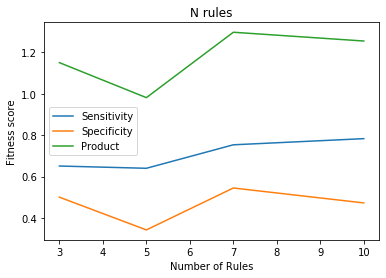

In [9]:
%load_ext autoreload
%autoreload

#Plot sen spe resuts
#read all csv
#--------------------
dataframe_results = pd.read_csv('values_number_of_rules.csv')
#--------------------

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results.head()

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = dataframe_results.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(dataframe_results, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)



libraries.interpretability_plots.plotSenSpeNRules(data_frame_treated, 'N rules')


### Finer search of parameters

The next step will be to perform a grid search for both parameters on a narrow range of values. For this, we need to define ranges for them.


<b style="background-color:red;color:white">Question 9</b>: On the base of the graphic above, select a narrower range for the number of rules to be explored in the next step. Justify your choice.
<br>
<b style="background-color:red;color:white">Question 10</b>: Then, define a range of values for the number of variables per rule. How did you decide on them? Why?

In [10]:
#Var per rule and number of rules


#--------------------
#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules_nvar/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules_nvar.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules_var'
#--------------------


model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)



#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience ('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [6,7,8]
var_per_rule_vec = [2,3,4,5]
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

gen	species	std      	min     	avg     	max  	avg_hof 
1  	sp1    	0.0572918	0.148148	0.295749	0.375	0.544795
1  	sp2    	0.24577  	0       	0.41555 	0.611111	0.593668
2  	sp1    	0.00732723	0.594595	0.606253	0.619718	0.614339
2  	sp2    	0.194465  	0       	0.479885	0.619718	0.614339
3  	sp1    	0.00874715	0.586667	0.607651	0.619718	0.617925
3  	sp2    	0.205814  	0       	0.467896	0.619718	0.617925
4  	sp1    	0.00876894	0.586667	0.609018	0.619718	0.619718
4  	sp2    	0.208481  	0       	0.464683	0.647059	0.620857
5  	sp1    	0.0097828 	0.594595	0.621953	0.637681	0.632758
5  	sp2    	0.202812  	0       	0.472517	0.637681	0.632758
6  	sp1    	0.0107722 	0.60274 	0.621108	0.637681	0.634276
6  	sp2    	0.218603  	0       	0.460333	0.637681	0.634276
7  	sp1    	0.0113257 	0.60274 	0.623547	0.637681	0.638072
7  	sp2    	0.23144   	0       	0.441782	0.637681	0.638072
8  	sp1    	0.0115855 	0.60274 	0.624995	0.637681	0.638072
8  	sp2    	0.195962  	0       	0.488412	0.637681	0.638072
9  	sp

70 	sp2    	0.251263  	0       	0.461972	0.727273	0.712708
71 	sp1    	0.0354428 	0.611111	0.669592	0.727273	0.713451
71 	sp2    	0.222494  	0       	0.475499	0.727273	0.713451
72 	sp1    	0.0345667 	0.611111	0.663618	0.727273	0.713552
72 	sp2    	0.236558  	0       	0.465974	0.727273	0.713552
73 	sp1    	0.0334023 	0.615385	0.666179	0.727273	0.713754
73 	sp2    	0.208433  	0       	0.512498	0.727273	0.713754
74 	sp1    	0.033822  	0.617647	0.669155	0.727273	0.714799
74 	sp2    	0.206216  	0       	0.50439 	0.727273	0.714799
75 	sp1    	0.0365932 	0.606061	0.665159	0.727273	0.716487
75 	sp2    	0.187781  	0       	0.523759	0.727273	0.716487
76 	sp1    	0.0348206 	0.606061	0.669204	0.727273	0.717532
76 	sp2    	0.232273  	0       	0.488565	0.727273	0.717532
77 	sp1    	0.0353252 	0.611111	0.666326	0.727273	0.718839
77 	sp2    	0.17793   	0       	0.527904	0.727273	0.718839
78 	sp1    	0.0336874 	0.615385	0.672571	0.727273	0.720034
78 	sp2    	0.189392  	0       	0.521699	0.727273	0.7201

39 	sp1    	0.0131792  	0.638889	0.690177	0.69697 	0.69697 
39 	sp2    	0.19859    	0       	0.53646 	0.69697 	0.69697 
40 	sp1    	0.00942577 	0.657143	0.689786	0.69697 	0.69697 
40 	sp2    	0.222649   	0       	0.506494	0.69697 	0.69697 
41 	sp1    	0.0107557  	0.647887	0.690863	0.69697 	0.69697 
41 	sp2    	0.195507   	0       	0.532962	0.69697 	0.69697 
42 	sp1    	0.0177329  	0.625   	0.674367	0.69697 	0.69697 
42 	sp2    	0.214522   	0       	0.515573	0.69697 	0.69697 
43 	sp1    	0.0142266  	0.638889	0.687127	0.69697 	0.69697 
43 	sp2    	0.219029   	0       	0.513868	0.69697 	0.69697 
44 	sp1    	0.0155664  	0.638889	0.687444	0.707692	0.698757
44 	sp2    	0.2242     	0       	0.509999	0.707692	0.698757
45 	sp1    	0.0143458  	0.638889	0.690483	0.707692	0.700097
45 	sp2    	0.204608   	0       	0.52937 	0.707692	0.700544
46 	sp1    	0.0187402  	0.621622	0.686967	0.707692	0.707246
46 	sp2    	0.210354   	0       	0.530518	0.707692	0.707692
47 	sp1    	0.0163779  	0.638889	0.69083

7  	sp1    	0.02639    	0.65    	0.674304	0.711864	0.711864
7  	sp2    	0.253064   	0       	0.514873	0.721311	0.712258
8  	sp1    	0.0366453  	0.641975	0.686433	0.721311	0.721311
8  	sp2    	0.211104   	0       	0.569425	0.721311	0.721311
9  	sp1    	0.0291088  	0.658228	0.689389	0.721311	0.721311
9  	sp2    	0.216375   	0       	0.565541	0.721311	0.721311
10 	sp1    	0.0338988  	0.641975	0.68538 	0.721311	0.721311
10 	sp2    	0.20589    	0       	0.567765	0.721311	0.721311
11 	sp1    	0.0333505  	0.641975	0.680063	0.721311	0.721311
11 	sp2    	0.186632   	0       	0.601618	0.724138	0.721547
12 	sp1    	0.0276101  	0.658228	0.688213	0.724138	0.723667
12 	sp2    	0.193329   	0       	0.588137	0.724138	0.723785
13 	sp1    	0.0251443  	0.666667	0.693144	0.724138	0.724138
13 	sp2    	0.207603   	0       	0.579456	0.741935	0.724879
14 	sp1    	0.0388857  	0.649351	0.698068	0.741935	0.741935
14 	sp2    	0.231829   	0       	0.553361	0.741935	0.741935
15 	sp1    	0.0416361  	0.641975	0.70064

75 	sp2    	0.205329   	0       	0.596897	0.787879	0.787879
76 	sp1    	0.0177702  	0.722222	0.771768	0.787879	0.787879
76 	sp2    	0.232424   	0       	0.563699	0.787879	0.787879
77 	sp1    	0.0153884  	0.732394	0.772552	0.787879	0.787879
77 	sp2    	0.215805   	0       	0.585813	0.787879	0.787879
78 	sp1    	0.016675   	0.722222	0.771555	0.787879	0.787879
78 	sp2    	0.211212   	0       	0.584448	0.787879	0.787879
79 	sp1    	0.0159671  	0.722222	0.773473	0.787879	0.787879
79 	sp2    	0.220503   	0       	0.587272	0.787879	0.787879
80 	sp1    	0.0148284  	0.732394	0.775107	0.787879	0.787879
80 	sp2    	0.241881   	0       	0.564894	0.787879	0.787879
81 	sp1    	0.0153365  	0.742857	0.775446	0.787879	0.787879
81 	sp2    	0.274963   	0       	0.513368	0.787879	0.787879
82 	sp1    	0.0140417  	0.732394	0.777447	0.787879	0.787879
82 	sp2    	0.258344   	0       	0.537335	0.787879	0.787879
83 	sp1    	0.011533   	0.742857	0.778262	0.787879	0.787879
83 	sp2    	0.206589   	0       	0.59452

44 	sp2    	0.195455 	0        	0.456653	0.655172	0.655172
45 	sp1    	0.0387832	0.539683 	0.608763	0.666667	0.655651
45 	sp2    	0.231146 	0        	0.398188	0.666667	0.656609
46 	sp1    	0.0331477	0.550725 	0.603995	0.666667	0.657088
46 	sp2    	0.208719 	0        	0.445724	0.666667	0.658046
47 	sp1    	0.0375709	0.547945 	0.601914	0.666667	0.658525
47 	sp2    	0.244993 	0        	0.383241	0.666667	0.659004
48 	sp1    	0.0391682	0.535211 	0.597206	0.666667	0.659962
48 	sp2    	0.204212 	0        	0.466051	0.666667	0.661398
49 	sp1    	0.0404804	0.540541 	0.598781	0.666667	0.663793
49 	sp2    	0.196923 	0        	0.472049	0.666667	0.66523 
50 	sp1    	0.0415988	0.535211 	0.604358	0.666667	0.665709
50 	sp2    	0.168067 	0        	0.495964	0.666667	0.666667
51 	sp1    	0.039334 	0.547945 	0.603044	0.666667	0.666667
51 	sp2    	0.2267   	0        	0.443999	0.666667	0.666667
52 	sp1    	0.0383878	0.555556 	0.615424	0.666667	0.666667
52 	sp2    	0.210036 	0        	0.465301	0.666667	0.6666

13 	sp2    	0.215415   	0       	0.444184	0.634921	0.635347
14 	sp1    	0.0208362  	0.575342	0.615681	0.634921	0.635347
14 	sp2    	0.198685   	0       	0.464088	0.634921	0.635347
15 	sp1    	0.0213913  	0.571429	0.612298	0.634921	0.635347
15 	sp2    	0.244182   	0       	0.403601	0.634921	0.635347
16 	sp1    	0.0213932  	0.571429	0.609749	0.634921	0.635347
16 	sp2    	0.176397   	0       	0.483549	0.634921	0.635347
17 	sp1    	0.0182142  	0.57971 	0.620188	0.634921	0.635347
17 	sp2    	0.228232   	0       	0.427937	0.634921	0.635347
18 	sp1    	0.0164061  	0.583333	0.624304	0.634921	0.635347
18 	sp2    	0.259256   	0       	0.375022	0.634921	0.635347
19 	sp1    	0.0202053  	0.571429	0.620334	0.645161	0.635774
19 	sp2    	0.231305   	0       	0.42411 	0.645161	0.635774
20 	sp1    	0.0179683  	0.571429	0.625208	0.645161	0.636201
20 	sp2    	0.197389   	0       	0.481402	0.646154	0.636669
21 	sp1    	0.0167919  	0.575342	0.633478	0.65625 	0.646995
21 	sp2    	0.200164   	0       	0.46810

82 	sp1    	0.0250909  	0.591549 	0.671201	0.688525	0.688525
82 	sp2    	0.221165   	0        	0.488881	0.688525	0.688525
83 	sp1    	0.0282555  	0.583333 	0.665072	0.688525	0.688525
83 	sp2    	0.195577   	0        	0.49303 	0.688525	0.688525
84 	sp1    	0.0285871  	0.591549 	0.66249 	0.688525	0.688525
84 	sp2    	0.1764     	0        	0.518903	0.688525	0.688525
85 	sp1    	0.0247082  	0.591549 	0.667797	0.688525	0.688525
85 	sp2    	0.1828     	0        	0.506477	0.688525	0.688525
86 	sp1    	0.023937   	0.6      	0.66756 	0.688525	0.688525
86 	sp2    	0.227736   	0        	0.455321	0.688525	0.688525
87 	sp1    	0.0252267  	0.591549 	0.661707	0.688525	0.688525
87 	sp2    	0.217047   	0        	0.458735	0.688525	0.688525
88 	sp1    	0.0272332  	0.591549 	0.667889	0.688525	0.688525
88 	sp2    	0.25557    	0        	0.416089	0.688525	0.688525
89 	sp1    	0.0218783  	0.6      	0.669619	0.688525	0.688525
89 	sp2    	0.21043    	0        	0.483451	0.688525	0.688525
90 	sp1    	0.0284555  	

51 	sp2    	0.189716 	0       	0.530445	0.758621	0.758621
52 	sp1    	0.0438302	0.611111	0.691231	0.758621	0.758621
52 	sp2    	0.197452 	0       	0.510228	0.758621	0.758621
53 	sp1    	0.0446752	0.615385	0.689176	0.758621	0.758621
53 	sp2    	0.204532 	0       	0.508324	0.758621	0.758621
54 	sp1    	0.0466216	0.617647	0.688568	0.758621	0.758621
54 	sp2    	0.205117 	0       	0.51441 	0.758621	0.758621
55 	sp1    	0.0481996	0.611111	0.691344	0.758621	0.758621
55 	sp2    	0.237674 	0       	0.461885	0.758621	0.758621
56 	sp1    	0.0483941	0.588235	0.687085	0.758621	0.758621
56 	sp2    	0.215215 	0       	0.480036	0.758621	0.758621
57 	sp1    	0.0435614	0.615385	0.689909	0.758621	0.758621
57 	sp2    	0.192374 	0       	0.510191	0.758621	0.758621
58 	sp1    	0.0462883	0.606061	0.688842	0.758621	0.758621
58 	sp2    	0.134667 	0       	0.558363	0.758621	0.758621
59 	sp1    	0.0445162	0.615385	0.692649	0.758621	0.758621
59 	sp2    	0.197738 	0       	0.511605	0.758621	0.758621
60 	sp1    	0.

22 	sp1    	0.062409 	0.605263	0.701071	0.77193 	0.77193 
22 	sp2    	0.212859 	0       	0.542593	0.77193 	0.77193 
23 	sp1    	0.05544  	0.60274 	0.720386	0.77193 	0.77193 
23 	sp2    	0.224993 	0       	0.52272 	0.77193 	0.77193 
24 	sp1    	0.0604792	0.60274 	0.716706	0.77193 	0.77193 
24 	sp2    	0.221556 	0       	0.524626	0.77193 	0.77193 
25 	sp1    	0.0549668	0.594595	0.719548	0.77193 	0.77193 
25 	sp2    	0.205882 	0       	0.526072	0.77193 	0.77193 
26 	sp1    	0.0549533	0.60274 	0.718219	0.77193 	0.77193 
26 	sp2    	0.202677 	0       	0.545533	0.77193 	0.77193 
27 	sp1    	0.0489537	0.611111	0.728149	0.77193 	0.77193 
27 	sp2    	0.211708 	0       	0.540303	0.77193 	0.77193 
28 	sp1    	0.0487488	0.60274 	0.723539	0.77193 	0.77193 
28 	sp2    	0.243099 	0       	0.511554	0.77193 	0.77193 
29 	sp1    	0.0506513	0.611111	0.716741	0.77193 	0.77193 
29 	sp2    	0.206294 	0       	0.548175	0.77193 	0.77193 
30 	sp1    	0.0533729	0.60274 	0.7114  	0.77193 	0.77193 
30 	sp2    	0.

93 	sp1    	0.0577348	0.619718	0.759912	0.807018	0.807018
93 	sp2    	0.209999 	0       	0.558375	0.807018	0.807018
94 	sp1    	0.061872 	0.630137	0.752279	0.807018	0.807018
94 	sp2    	0.222014 	0       	0.547699	0.807018	0.807018
95 	sp1    	0.0615632	0.638889	0.759423	0.807018	0.807018
95 	sp2    	0.227735 	0       	0.51166 	0.807018	0.807018
96 	sp1    	0.0639378	0.630137	0.746965	0.807018	0.807018
96 	sp2    	0.191465 	0       	0.547085	0.807018	0.807018
97 	sp1    	0.0587934	0.630137	0.743862	0.807018	0.807018
97 	sp2    	0.195605 	0       	0.543753	0.807018	0.807018
98 	sp1    	0.0619021	0.611111	0.742644	0.807018	0.807018
98 	sp2    	0.218932 	0       	0.526792	0.807018	0.807018
99 	sp1    	0.0638488	0.619718	0.737634	0.807018	0.807018
99 	sp2    	0.236115 	0       	0.499849	0.807018	0.807018
100	sp1    	0.0611119	0.619718	0.736525	0.807018	0.807018
100	sp2    	0.219576 	0       	0.543885	0.807018	0.807018
save end
gen	species	std      	min    	avg     	max     	avg_hof 
1  	sp

62 	sp2    	0.283493  	0       	0.515782	0.793651	0.793651
63 	sp1    	0.0222277 	0.702703	0.763503	0.793651	0.793651
63 	sp2    	0.302559  	0       	0.497837	0.793651	0.793651
64 	sp1    	0.0231076 	0.693333	0.761956	0.793651	0.793651
64 	sp2    	0.277779  	0       	0.543281	0.793651	0.793651
65 	sp1    	0.0254775 	0.693333	0.759076	0.793651	0.793651
65 	sp2    	0.249393  	0       	0.58519 	0.793651	0.793651
66 	sp1    	0.0248578 	0.693333	0.762649	0.793651	0.793651
66 	sp2    	0.276545  	0       	0.520852	0.793651	0.793651
67 	sp1    	0.0243751 	0.693333	0.761708	0.793651	0.793651
67 	sp2    	0.278108  	0       	0.53797 	0.793651	0.793651
68 	sp1    	0.0274737 	0.693333	0.762319	0.793651	0.793651
68 	sp2    	0.247507  	0       	0.566036	0.793651	0.793651
69 	sp1    	0.0289399 	0.675325	0.76259 	0.793651	0.793651
69 	sp2    	0.285805  	0       	0.523633	0.793651	0.793651
70 	sp1    	0.0285467 	0.693333	0.76204 	0.793651	0.793651
70 	sp2    	0.28071   	0       	0.522208	0.793651	0.7936

30 	sp2    	0.226027  	0        	0.434558 	0.690909 	0.690909
31 	sp1    	0.0246994 	0.603175 	0.66892  	0.690909 	0.690909
31 	sp2    	0.185368  	0        	0.485396 	0.690909 	0.690909
32 	sp1    	0.0231494 	0.610169 	0.66647  	0.690909 	0.690909
32 	sp2    	0.179266  	0        	0.492939 	0.690909 	0.690909
33 	sp1    	0.0245812 	0.584615 	0.666677 	0.690909 	0.690909
33 	sp2    	0.210895  	0        	0.463926 	0.690909 	0.690909
34 	sp1    	0.0291084 	0.584615 	0.662737 	0.690909 	0.690909
34 	sp2    	0.187381  	0        	0.508067 	0.690909 	0.690909
35 	sp1    	0.0277013 	0.6      	0.660147 	0.690909 	0.690909
35 	sp2    	0.188188  	0        	0.495022 	0.690909 	0.690909
36 	sp1    	0.024468  	0.603175 	0.66393  	0.690909 	0.690909
36 	sp2    	0.185743  	0        	0.495913 	0.690909 	0.690909
37 	sp1    	0.0209026 	0.612903 	0.668229 	0.690909 	0.690909
37 	sp2    	0.193747  	0        	0.472794 	0.690909 	0.690909
38 	sp1    	0.0229253 	0.6      	0.667852 	0.703704 	0.691442
38 	sp2 

97 	sp1    	0.0258241 	0.631579 	0.684576 	0.716981 	0.716981
97 	sp2    	0.192116  	0        	0.504063 	0.716981 	0.716981
98 	sp1    	0.028634  	0.612903 	0.685055 	0.716981 	0.716981
98 	sp2    	0.202756  	0        	0.494307 	0.716981 	0.716981
99 	sp1    	0.0288199 	0.596491 	0.683979 	0.716981 	0.716981
99 	sp2    	0.21432   	0        	0.465642 	0.716981 	0.716981
100	sp1    	0.0289725 	0.590164 	0.686813 	0.716981 	0.716981
100	sp2    	0.230645  	0        	0.463048 	0.716981 	0.716981
save end
gen	species	std	min     	avg     	max     	avg_hof 
1  	sp1    	0  	0.506667	0.506667	0.506667	0.531881
1  	sp2    	0.216319	0       	0.389027	0.585366	0.557213
2  	sp1    	0.0115849	0.547945	0.572845	0.585366	0.585366
2  	sp2    	0.222105 	0       	0.403237	0.585366	0.585366
3  	sp1    	0.018427 	0.514286	0.570773	0.585366	0.585366
3  	sp2    	0.20738  	0       	0.434388	0.588235	0.585485
4  	sp1    	0.0155922	0.545455	0.577701	0.617647	0.59193 
4  	sp2    	0.21624  	0       	0.428133	0.61

67 	sp1    	0.0204717	0.588235	0.637063	0.666667	0.662326
67 	sp2    	0.234667 	0       	0.437311	0.666667	0.66276 
68 	sp1    	0.019653 	0.6     	0.639942	0.666667	0.666667
68 	sp2    	0.179298 	0       	0.496742	0.666667	0.666667
69 	sp1    	0.0209093	0.591549	0.637705	0.666667	0.666667
69 	sp2    	0.192996 	0       	0.482982	0.666667	0.666667
70 	sp1    	0.0220831	0.588235	0.637044	0.666667	0.666667
70 	sp2    	0.236289 	0       	0.429624	0.666667	0.666667
71 	sp1    	0.0190762	0.6     	0.640107	0.666667	0.666667
71 	sp2    	0.220753 	0       	0.456962	0.666667	0.666667
72 	sp1    	0.0160259	0.588235	0.646043	0.666667	0.666667
72 	sp2    	0.189226 	0       	0.494563	0.666667	0.666667
73 	sp1    	0.0197687	0.591549	0.640278	0.666667	0.666667
73 	sp2    	0.154315 	0       	0.515025	0.666667	0.666667
74 	sp1    	0.0197429	0.597015	0.642776	0.666667	0.666667
74 	sp2    	0.189188 	0       	0.498745	0.666667	0.666667
75 	sp1    	0.0152607	0.608696	0.648629	0.666667	0.666667
75 	sp2    	0.

37 	sp1    	0.0191083 	0.626866	0.667584	0.690909	0.690909
37 	sp2    	0.213347  	0       	0.496751	0.690909	0.690909
38 	sp1    	0.0140866 	0.646154	0.679627	0.703704	0.69456 
38 	sp2    	0.25314   	0       	0.456204	0.703704	0.69456 
39 	sp1    	0.0185685 	0.636364	0.680271	0.703704	0.698743
39 	sp2    	0.227511  	0       	0.503607	0.703704	0.698743
40 	sp1    	0.0189245 	0.64    	0.675287	0.703704	0.702313
40 	sp2    	0.231869  	0       	0.488205	0.703704	0.702313
41 	sp1    	0.0174234 	0.646154	0.682661	0.703704	0.703704
41 	sp2    	0.169975  	0       	0.548265	0.703704	0.703704
42 	sp1    	0.0192182 	0.636364	0.683297	0.703704	0.703704
42 	sp2    	0.225923  	0       	0.499272	0.703704	0.703704
43 	sp1    	0.0191743 	0.646154	0.685613	0.703704	0.703704
43 	sp2    	0.229066  	0       	0.479735	0.703704	0.703704
44 	sp1    	0.0224744 	0.636364	0.681608	0.703704	0.703704
44 	sp2    	0.206477  	0       	0.508107	0.703704	0.703704
45 	sp1    	0.0178402 	0.645161	0.685204	0.703704	0.7037

6  	sp2    	0.241097   	0       	0.465196	0.656716	0.646381
7  	sp1    	0.0186335  	0.605263	0.623591	0.656716	0.648972
7  	sp2    	0.232346   	0       	0.483563	0.656716	0.648972
8  	sp1    	0.00703596 	0.630137	0.643105	0.656716	0.649339
8  	sp2    	0.252998   	0       	0.436241	0.666667	0.650893
9  	sp1    	0.0156566  	0.621622	0.636885	0.666667	0.660554
9  	sp2    	0.249264   	0       	0.448917	0.666667	0.661005
10 	sp1    	0.0213467  	0.605263	0.637333	0.666667	0.663889
10 	sp2    	0.237643   	0       	0.468602	0.676471	0.665091
11 	sp1    	0.0291163  	0.571429	0.639285	0.676471	0.671977
11 	sp2    	0.25216    	0       	0.4478  	0.676471	0.671977
12 	sp1    	0.0299968  	0.571429	0.64239 	0.676471	0.675245
12 	sp2    	0.219531   	0       	0.503009	0.676471	0.675654
13 	sp1    	0.0319074  	0.571429	0.640589	0.676471	0.676471
13 	sp2    	0.237498   	0       	0.473962	0.676471	0.676471
14 	sp1    	0.0504682  	0.487805	0.632338	0.676471	0.676471
14 	sp2    	0.234894   	0       	0.49049

75 	sp1    	0.0370051  	0.631579	0.710747	0.754098	0.754098
75 	sp2    	0.254427   	0       	0.507118	0.754098	0.754098
76 	sp1    	0.0376066  	0.631579	0.709004	0.754098	0.754098
76 	sp2    	0.257193   	0       	0.500068	0.754098	0.754098
77 	sp1    	0.0353354  	0.62069 	0.706346	0.754098	0.754098
77 	sp2    	0.27506    	0       	0.468939	0.754098	0.754098
78 	sp1    	0.0361814  	0.62069 	0.709014	0.754098	0.754098
78 	sp2    	0.284183   	0       	0.449614	0.754098	0.754098
79 	sp1    	0.0371475  	0.631579	0.70933 	0.754098	0.754098
79 	sp2    	0.255485   	0       	0.462499	0.754098	0.754098
80 	sp1    	0.0356707  	0.625   	0.71498 	0.754098	0.754098
80 	sp2    	0.264081   	0       	0.466183	0.754098	0.754098
81 	sp1    	0.0337423  	0.621622	0.714384	0.754098	0.754098
81 	sp2    	0.268627   	0       	0.46106 	0.754098	0.754098
82 	sp1    	0.0299614  	0.631579	0.71993 	0.754098	0.754098
82 	sp2    	0.257547   	0       	0.467222	0.754098	0.754098
83 	sp1    	0.0329335  	0.631579	0.71828

42 	sp2    	0.279464  	0       	0.490392 	0.753623 	0.753623
43 	sp1    	0.0175486 	0.684211	0.728322 	0.753623 	0.753623
43 	sp2    	0.284563  	0       	0.48132  	0.753623 	0.753623
44 	sp1    	0.0188553 	0.684211	0.728238 	0.753623 	0.753623
44 	sp2    	0.280763  	0       	0.490731 	0.753623 	0.753623
45 	sp1    	0.0188267 	0.684211	0.728196 	0.753623 	0.753623
45 	sp2    	0.268226  	0       	0.514949 	0.753623 	0.753623
46 	sp1    	0.0204051 	0.684211	0.727864 	0.753623 	0.753623
46 	sp2    	0.228431  	0       	0.559099 	0.753623 	0.753623
47 	sp1    	0.0215135 	0.676056	0.725076 	0.753623 	0.753623
47 	sp2    	0.293197  	0       	0.448062 	0.753623 	0.753623
48 	sp1    	0.0209723 	0.676056	0.721185 	0.753623 	0.753623
48 	sp2    	0.285635  	0       	0.476036 	0.753623 	0.753623
49 	sp1    	0.022859  	0.676056	0.71798  	0.753623 	0.753623
49 	sp2    	0.261018  	0       	0.522665 	0.753623 	0.753623
50 	sp1    	0.0218106 	0.676056	0.722536 	0.753623 	0.753623
50 	sp2    	0.282972  	0

10 	sp1    	0.0127385	0.571429	0.610724	0.634921	0.625827
10 	sp2    	0.226758 	0       	0.417634	0.634921	0.625827
11 	sp1    	0.0111112	0.588235	0.61535 	0.634921	0.627067
11 	sp2    	0.218824 	0       	0.427005	0.64    	0.627692
12 	sp1    	0.0155434	0.571429	0.608589	0.64    	0.629355
12 	sp2    	0.230133 	0       	0.413018	0.64    	0.629769
13 	sp1    	0.0156629	0.57971 	0.612108	0.64    	0.631422
13 	sp2    	0.231011 	0       	0.420967	0.64    	0.631422
14 	sp1    	0.0158696	0.588235	0.616402	0.64    	0.63619 
14 	sp2    	0.219591 	0       	0.432047	0.64    	0.63619 
15 	sp1    	0.0173257	0.57971 	0.61751 	0.64    	0.637884
15 	sp2    	0.251668 	0       	0.386144	0.64    	0.637884
16 	sp1    	0.0305669	0.547945	0.601207	0.64    	0.64    
16 	sp2    	0.221427 	0       	0.440175	0.64    	0.64    
17 	sp1    	0.0167214	0.57971 	0.621583	0.64    	0.64    
17 	sp2    	0.243574 	0       	0.411016	0.64    	0.64    
18 	sp1    	0.0307135	0.547945	0.604666	0.641509	0.640126
18 	sp2    	0.

81 	sp1    	0.0496491	0.575758	0.685631	0.75    	0.74426 
81 	sp2    	0.215062 	0       	0.463805	0.75    	0.74426 
82 	sp1    	0.0425341	0.6     	0.694622	0.75    	0.746811
82 	sp2    	0.239745 	0       	0.44092 	0.75    	0.747449
83 	sp1    	0.0471467	0.606061	0.696024	0.75    	0.75    
83 	sp2    	0.249431 	0       	0.456817	0.75    	0.75    
84 	sp1    	0.0375391	0.631579	0.707066	0.75    	0.75    
84 	sp2    	0.218562 	0       	0.489312	0.75    	0.75    
85 	sp1    	0.038878 	0.625   	0.701771	0.75    	0.75    
85 	sp2    	0.235806 	0       	0.466688	0.75    	0.75    
86 	sp1    	0.0338418	0.625   	0.702714	0.75    	0.75    
86 	sp2    	0.235817 	0       	0.459326	0.75    	0.75    
87 	sp1    	0.0370733	0.631579	0.696027	0.75    	0.75    
87 	sp2    	0.218293 	0       	0.471413	0.75    	0.75    
88 	sp1    	0.0387783	0.634146	0.691523	0.75    	0.75    
88 	sp2    	0.224143 	0       	0.472208	0.75    	0.75    
89 	sp1    	0.041052 	0.615385	0.699314	0.75    	0.75    
89 	sp2    	0.

49 	sp1    	0.0250538 	0.6     	0.641548 	0.677966 	0.677966
49 	sp2    	0.226787  	0       	0.4241   	0.677966 	0.677966
50 	sp1    	0.0243212 	0.6     	0.643042 	0.677966 	0.677966
50 	sp2    	0.210866  	0       	0.459585 	0.677966 	0.677966
51 	sp1    	0.0234149 	0.6     	0.645773 	0.677966 	0.677966
51 	sp2    	0.229371  	0       	0.435102 	0.677966 	0.677966
52 	sp1    	0.0248762 	0.6     	0.645684 	0.677966 	0.677966
52 	sp2    	0.190705  	0       	0.483043 	0.677966 	0.677966
53 	sp1    	0.024953  	0.6     	0.646462 	0.677966 	0.677966
53 	sp2    	0.249759  	0       	0.408959 	0.677966 	0.677966
54 	sp1    	0.024071  	0.6     	0.649948 	0.677966 	0.677966
54 	sp2    	0.23151   	0       	0.443739 	0.677966 	0.677966
55 	sp1    	0.0239053 	0.6     	0.653008 	0.677966 	0.677966
55 	sp2    	0.231112  	0       	0.447931 	0.677966 	0.677966
56 	sp1    	0.0220369 	0.608696	0.653421 	0.677966 	0.677966
56 	sp2    	0.215348  	0       	0.469931 	0.677966 	0.677966
57 	sp1    	0.0220801 	0

17 	sp1    	0.0323156 	0.591549	0.645559	0.698413	0.689404
17 	sp2    	0.25686   	0       	0.433626	0.698413	0.689447
18 	sp1    	0.0358089 	0.591549	0.648698	0.698413	0.691266
18 	sp2    	0.27632   	0       	0.433922	0.698413	0.691763
19 	sp1    	0.0308719 	0.60274 	0.660175	0.698413	0.698001
19 	sp2    	0.267638  	0       	0.441704	0.698413	0.698413
20 	sp1    	0.031474  	0.591549	0.663406	0.698413	0.698413
20 	sp2    	0.243974  	0       	0.475224	0.698413	0.698413
21 	sp1    	0.0294353 	0.6     	0.665451	0.698413	0.698413
21 	sp2    	0.249375  	0       	0.483295	0.698413	0.698413
22 	sp1    	0.0306215 	0.6     	0.659679	0.698413	0.698413
22 	sp2    	0.280553  	0       	0.384469	0.698413	0.698413
23 	sp1    	0.0302638 	0.594595	0.660181	0.698413	0.698413
23 	sp2    	0.254729  	0       	0.437365	0.698413	0.698413
24 	sp1    	0.0302542 	0.6     	0.658   	0.698413	0.698413
24 	sp2    	0.241185  	0       	0.479407	0.698413	0.698413
25 	sp1    	0.0288262 	0.608696	0.663233	0.698413	0.6984

86 	sp2    	0.275557  	0       	0.434043	0.745763	0.745763
87 	sp1    	0.0364124 	0.611111	0.704254	0.745763	0.745763
87 	sp2    	0.276139  	0       	0.450992	0.745763	0.745763
88 	sp1    	0.0345688 	0.626866	0.702868	0.745763	0.745763
88 	sp2    	0.294789  	0       	0.42418 	0.745763	0.745763
89 	sp1    	0.0311004 	0.628571	0.708498	0.745763	0.745763
89 	sp2    	0.255182  	0       	0.490205	0.745763	0.745763
90 	sp1    	0.0373589 	0.611111	0.698221	0.745763	0.745763
90 	sp2    	0.260617  	0       	0.488531	0.745763	0.745763
91 	sp1    	0.0389405 	0.591549	0.696695	0.745763	0.745763
91 	sp2    	0.265072  	0       	0.472336	0.745763	0.745763
92 	sp1    	0.0364083 	0.617647	0.698145	0.745763	0.745763
92 	sp2    	0.260778  	0       	0.487513	0.745763	0.745763
93 	sp1    	0.0352338 	0.608696	0.700029	0.745763	0.745763
93 	sp2    	0.251469  	0       	0.504635	0.745763	0.745763
94 	sp1    	0.0358002 	0.626866	0.702618	0.745763	0.745763
94 	sp2    	0.263088  	0       	0.491009	0.745763	0.7457

57 	sp1    	0.0206383	0.619718	0.68882 	0.709677	0.709677
57 	sp2    	0.280136 	0       	0.442292	0.709677	0.709677
58 	sp1    	0.0213366	0.619718	0.690574	0.709677	0.709677
58 	sp2    	0.266765 	0       	0.469765	0.709677	0.709677
59 	sp1    	0.0192926	0.656716	0.691271	0.709677	0.709677
59 	sp2    	0.274566 	0       	0.452765	0.709677	0.709677
60 	sp1    	0.0178749	0.656716	0.690924	0.709677	0.709677
60 	sp2    	0.275092 	0       	0.453522	0.709677	0.709677
61 	sp1    	0.0179723	0.656716	0.689254	0.709677	0.709677
61 	sp2    	0.27921  	0       	0.445632	0.709677	0.709677
62 	sp1    	0.019261 	0.619718	0.691533	0.709677	0.709677
62 	sp2    	0.264312 	0       	0.46782 	0.709677	0.709677
63 	sp1    	0.0210276	0.619718	0.69262 	0.709677	0.709677
63 	sp2    	0.274274 	0       	0.455977	0.709677	0.709677
64 	sp1    	0.0185211	0.647887	0.693492	0.709677	0.709677
64 	sp2    	0.285914 	0       	0.441902	0.709677	0.709677
65 	sp1    	0.016978 	0.647059	0.695675	0.709677	0.709677
65 	sp2    	0.

26 	sp2    	0.305843  	0        	0.475077	0.793103	0.793103
27 	sp1    	0.021209  	0.71875  	0.765767	0.793103	0.793103
27 	sp2    	0.290275  	0        	0.500645	0.793103	0.793103
28 	sp1    	0.0232624 	0.716418 	0.766213	0.793103	0.793103
28 	sp2    	0.285358  	0        	0.524848	0.821429	0.794284
29 	sp1    	0.0272554 	0.709677 	0.796911	0.821429	0.821429
29 	sp2    	0.293889  	0        	0.511314	0.821429	0.821429
30 	sp1    	0.0258395 	0.709677 	0.795251	0.821429	0.821429
30 	sp2    	0.281016  	0        	0.527694	0.821429	0.821429
31 	sp1    	0.0222381 	0.75     	0.802223	0.821429	0.821429
31 	sp2    	0.263113  	0        	0.551034	0.821429	0.821429
32 	sp1    	0.0167473 	0.754098 	0.807795	0.821429	0.821429
32 	sp2    	0.27119   	0        	0.538874	0.821429	0.821429
33 	sp1    	0.023526  	0.741935 	0.802739	0.821429	0.821429
33 	sp2    	0.291217  	0        	0.48652 	0.821429	0.821429
34 	sp1    	0.02226   	0.741935 	0.801812	0.821429	0.821429
34 	sp2    	0.283535  	0        	0.50555

95 	sp1    	0.0239419 	0.766667 	0.830625	0.857143	0.854718
95 	sp2    	0.296881  	0        	0.54476 	0.857143	0.854718
96 	sp1    	0.0238117 	0.779661 	0.831276	0.857143	0.856041
96 	sp2    	0.294647  	0        	0.554486	0.857143	0.856041
97 	sp1    	0.0242122 	0.777778 	0.830209	0.857143	0.857143
97 	sp2    	0.311449  	0        	0.505271	0.857143	0.857143
98 	sp1    	0.0250808 	0.766667 	0.830155	0.857143	0.857143
98 	sp2    	0.30386   	0        	0.518637	0.857143	0.857143
99 	sp1    	0.0236127 	0.774194 	0.832009	0.857143	0.857143
99 	sp2    	0.308077  	0        	0.525646	0.857143	0.857143
100	sp1    	0.0247818 	0.766667 	0.833168	0.857143	0.857143
100	sp2    	0.268285  	0        	0.554633	0.857143	0.857143
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.204588
1  	sp2    	0.242474	0  	0.277198	0.57971	0.544239
2  	sp1    	0.00904417	0.558824	0.564045	0.57971	0.551699
2  	sp2    	0.238448  	0       	0.363108	0.584615	0.558624
3  	sp1    	0.0138425 	0.5507

64 	sp2    	0.226951  	0       	0.465731	0.678571	0.678571
65 	sp1    	0.0314035 	0.57971 	0.647886	0.678571	0.678571
65 	sp2    	0.249066  	0       	0.441947	0.678571	0.678571
66 	sp1    	0.0291807 	0.596491	0.651977	0.678571	0.678571
66 	sp2    	0.264053  	0       	0.427232	0.678571	0.678571
67 	sp1    	0.0298099 	0.59375 	0.651225	0.678571	0.678571
67 	sp2    	0.226527  	0       	0.462905	0.678571	0.678571
68 	sp1    	0.0328183 	0.558824	0.648684	0.678571	0.678571
68 	sp2    	0.263526  	0       	0.394808	0.678571	0.678571
69 	sp1    	0.0355845 	0.584615	0.642748	0.678571	0.678571
69 	sp2    	0.254736  	0       	0.418545	0.678571	0.678571
70 	sp1    	0.0378418 	0.566667	0.644217	0.678571	0.678571
70 	sp2    	0.231986  	0       	0.443621	0.678571	0.678571
71 	sp1    	0.0359056 	0.566667	0.646138	0.678571	0.678571
71 	sp2    	0.255987  	0       	0.397867	0.678571	0.678571
72 	sp1    	0.0325654 	0.590164	0.647922	0.678571	0.678571
72 	sp2    	0.265896  	0       	0.392213	0.678571	0.6785

34 	sp2    	0.263368 	0       	0.43551 	0.730769	0.730769
35 	sp1    	0.0255878	0.644068	0.707434	0.730769	0.730769
35 	sp2    	0.235287 	0       	0.47461 	0.730769	0.730769
36 	sp1    	0.0240695	0.655172	0.705834	0.730769	0.730769
36 	sp2    	0.239657 	0       	0.45379 	0.730769	0.730769
37 	sp1    	0.0221178	0.636364	0.711413	0.730769	0.730769
37 	sp2    	0.246091 	0       	0.439926	0.745098	0.731366
38 	sp1    	0.0202008	0.655738	0.723182	0.745098	0.745098
38 	sp2    	0.237311 	0       	0.44602 	0.745098	0.745098
39 	sp1    	0.0256568	0.646154	0.719852	0.745098	0.745098
39 	sp2    	0.223633 	0       	0.479629	0.745098	0.745098
40 	sp1    	0.0246085	0.645161	0.722171	0.745098	0.745098
40 	sp2    	0.266561 	0       	0.423925	0.745098	0.745098
41 	sp1    	0.0245161	0.645161	0.72424 	0.76    	0.74634 
41 	sp2    	0.220853 	0       	0.50543 	0.76    	0.74634 
42 	sp1    	0.0268017	0.666667	0.71973 	0.76    	0.746961
42 	sp2    	0.247336 	0       	0.454818	0.76    	0.746961
43 	sp1    	0.

4  	sp2    	0.139703   	0       	0.529161	0.637681	0.628593
5  	sp1    	0.0091503  	0.594595	0.61946 	0.637681	0.630469
5  	sp2    	0.146495   	0       	0.531968	0.637681	0.630469
6  	sp1    	0.0151854  	0.586667	0.613294	0.637681	0.633126
6  	sp2    	0.190102   	0       	0.49221 	0.637681	0.633506
7  	sp1    	0.019274   	0.578947	0.608335	0.637681	0.637681
7  	sp2    	0.180283   	0       	0.50883 	0.637681	0.637681
8  	sp1    	0.0155091  	0.586667	0.618276	0.637681	0.637681
8  	sp2    	0.217008   	0       	0.471779	0.637681	0.637681
9  	sp1    	0.0145864  	0.594595	0.617512	0.646154	0.638034
9  	sp2    	0.200343   	0       	0.488381	0.646154	0.638387
10 	sp1    	0.0157789  	0.60274 	0.638212	0.666667	0.656357
10 	sp2    	0.203424   	0       	0.49273 	0.666667	0.657249
11 	sp1    	0.0173775  	0.60274 	0.651258	0.676923	0.667094
11 	sp2    	0.165717   	0       	0.519838	0.676923	0.667521
12 	sp1    	0.0244068  	0.591549	0.638306	0.676923	0.667949
12 	sp2    	0.199726   	0       	0.49442

72 	sp2    	0.203837   	0        	0.518992	0.75    	0.75    
73 	sp1    	0.0493278  	0.60274  	0.688039	0.75    	0.75    
73 	sp2    	0.228339   	0        	0.488793	0.75    	0.75    
74 	sp1    	0.049      	0.60274  	0.68846 	0.75    	0.75    
74 	sp2    	0.210406   	0        	0.518397	0.75    	0.75    
75 	sp1    	0.0495035  	0.60274  	0.688393	0.75    	0.75    
75 	sp2    	0.224271   	0        	0.511171	0.75    	0.75    
76 	sp1    	0.0486005  	0.594595 	0.693525	0.75    	0.75    
76 	sp2    	0.203976   	0        	0.525743	0.75    	0.75    
77 	sp1    	0.0462647  	0.60274  	0.695155	0.75    	0.75    
77 	sp2    	0.204637   	0        	0.541435	0.75    	0.75    
78 	sp1    	0.0442079  	0.60274  	0.697654	0.75    	0.75    
78 	sp2    	0.247663   	0        	0.474986	0.75    	0.75    
79 	sp1    	0.0413806  	0.60274  	0.685803	0.75    	0.75    
79 	sp2    	0.231969   	0        	0.489806	0.75    	0.75    
80 	sp1    	0.0448555  	0.611111 	0.686901	0.75    	0.75    
80 	sp2    	0.2162     	

41 	sp1    	0.0272868 	0.628571	0.68876 	0.745763	0.725422
41 	sp2    	0.210966  	0       	0.537478	0.745763	0.725422
42 	sp1    	0.0353876 	0.594595	0.680632	0.745763	0.725422
42 	sp2    	0.197464  	0       	0.5467  	0.745763	0.726164
43 	sp1    	0.0338215 	0.60274 	0.690481	0.745763	0.727065
43 	sp2    	0.210646  	0       	0.539966	0.745763	0.727448
44 	sp1    	0.0350032 	0.603175	0.689724	0.745763	0.728743
44 	sp2    	0.226104  	0       	0.517351	0.745763	0.728743
45 	sp1    	0.0373166 	0.603175	0.687969	0.745763	0.731682
45 	sp2    	0.174358  	0       	0.564931	0.745763	0.732065
46 	sp1    	0.0351971 	0.603175	0.687532	0.745763	0.732831
46 	sp2    	0.234093  	0       	0.50429 	0.745763	0.732831
47 	sp1    	0.0377051 	0.603175	0.685578	0.745763	0.735609
47 	sp2    	0.219414  	0       	0.515811	0.745763	0.735993
48 	sp1    	0.0389881 	0.615385	0.689077	0.745763	0.739189
48 	sp2    	0.224185  	0       	0.514939	0.745763	0.739189
49 	sp1    	0.0421253 	0.596491	0.690255	0.745763	0.7414

10 	sp1    	0.0140292 	0.656716 	0.679824	0.712329	0.701144
10 	sp2    	0.178145  	0        	0.588801	0.712329	0.702635
11 	sp1    	0.0128287 	0.666667 	0.684198	0.712329	0.703969
11 	sp2    	0.20223   	0        	0.564081	0.712329	0.703969
12 	sp1    	0.0178223 	0.641975 	0.682914	0.712329	0.704772
12 	sp2    	0.193068  	0        	0.574883	0.712329	0.705574
13 	sp1    	0.0169502 	0.641975 	0.682946	0.712329	0.706439
13 	sp2    	0.224485  	0        	0.542729	0.712329	0.707643
14 	sp1    	0.0191216 	0.641975 	0.682959	0.71875 	0.711246
14 	sp2    	0.230017  	0        	0.549918	0.727273	0.714022
15 	sp1    	0.0186834 	0.641975 	0.687983	0.727273	0.714434
15 	sp2    	0.189913  	0        	0.58509 	0.727273	0.716164
16 	sp1    	0.0203738 	0.637681 	0.690228	0.730159	0.717942
16 	sp2    	0.212133  	0        	0.566589	0.730159	0.720914
17 	sp1    	0.0187178 	0.649351 	0.692704	0.730159	0.721861
17 	sp2    	0.205844  	0        	0.55534 	0.730159	0.721861
18 	sp1    	0.0202687 	0.65     	0.69325

78 	sp2    	0.216747  	0        	0.579924	0.807018	0.807018
79 	sp1    	0.0316442 	0.685714 	0.763401	0.807018	0.807018
79 	sp2    	0.250494  	0        	0.537099	0.807018	0.807018
80 	sp1    	0.0344664 	0.685714 	0.757822	0.807018	0.807018
80 	sp2    	0.202706  	0        	0.596008	0.807018	0.807018
81 	sp1    	0.0371316 	0.685714 	0.756027	0.807018	0.807018
81 	sp2    	0.227607  	0        	0.558673	0.807018	0.807018
82 	sp1    	0.0413612 	0.676471 	0.744872	0.807018	0.807018
82 	sp2    	0.236895  	0        	0.567826	0.807018	0.807018
83 	sp1    	0.0352624 	0.676471 	0.752432	0.807018	0.807018
83 	sp2    	0.253491  	0        	0.560184	0.807018	0.807018
84 	sp1    	0.0374357 	0.676471 	0.754557	0.807018	0.807018
84 	sp2    	0.245694  	0        	0.548702	0.807018	0.807018
85 	sp1    	0.0335215 	0.684932 	0.752448	0.807018	0.807018
85 	sp2    	0.267938  	0        	0.528058	0.807018	0.807018
86 	sp1    	0.0352947 	0.686567 	0.749872	0.807018	0.807018
86 	sp2    	0.221861  	0        	0.58277

46 	sp2    	0.205873   	0       	0.440999	0.682927	0.68228 
47 	sp1    	0.0574191  	0.540541	0.625495	0.682927	0.682511
47 	sp2    	0.179489   	0       	0.470529	0.682927	0.682511
48 	sp1    	0.0489224  	0.542857	0.625045	0.682927	0.682557
48 	sp2    	0.179437   	0       	0.480784	0.682927	0.682603
49 	sp1    	0.0519266  	0.540541	0.620426	0.682927	0.682927
49 	sp2    	0.171149   	0       	0.474345	0.682927	0.682927
50 	sp1    	0.0565659  	0.540541	0.616912	0.682927	0.682927
50 	sp2    	0.168984   	0       	0.484756	0.682927	0.682927
51 	sp1    	0.0572474  	0.533333	0.613956	0.682927	0.682927
51 	sp2    	0.202321   	0       	0.464734	0.682927	0.682927
52 	sp1    	0.0610034  	0.533333	0.613877	0.682927	0.682927
52 	sp2    	0.212202   	0       	0.429422	0.682927	0.682927
53 	sp1    	0.0602362  	0.533333	0.626479	0.682927	0.682927
53 	sp2    	0.152117   	0       	0.504676	0.682927	0.682927
54 	sp1    	0.0604189  	0.513514	0.625207	0.682927	0.682927
54 	sp2    	0.209125   	0       	0.45544

14 	sp2    	0.155598   	0       	0.494071	0.617647	0.617647
15 	sp1    	0.0126359  	0.575342	0.605596	0.617647	0.617647
15 	sp2    	0.19078    	0       	0.479031	0.636364	0.618427
16 	sp1    	0.0218619  	0.555556	0.594295	0.636364	0.619987
16 	sp2    	0.18817    	0       	0.458639	0.636364	0.620755
17 	sp1    	0.0175294  	0.56    	0.606244	0.636364	0.627308
17 	sp2    	0.193697   	0       	0.45393 	0.636364	0.62846 
18 	sp1    	0.0154511  	0.567568	0.607917	0.636364	0.62924 
18 	sp2    	0.184635   	0       	0.478927	0.636364	0.62924 
19 	sp1    	0.0242568  	0.56338 	0.599727	0.636364	0.629636
19 	sp2    	0.206269   	0       	0.447507	0.636364	0.630032
20 	sp1    	0.0234409  	0.550725	0.597188	0.636364	0.631615
20 	sp2    	0.159916   	0       	0.492596	0.636364	0.632406
21 	sp1    	0.0167255  	0.575342	0.611505	0.636364	0.635176
21 	sp2    	0.206287   	0       	0.448374	0.636364	0.635572
22 	sp1    	0.0218112  	0.576271	0.624901	0.666667	0.649223
22 	sp2    	0.216789   	0       	0.43785

83 	sp1    	0.0317766  	0.583333	0.6798  	0.711864	0.711864
83 	sp2    	0.232511   	0       	0.451685	0.711864	0.711864
84 	sp1    	0.0302968  	0.580645	0.678042	0.711864	0.711864
84 	sp2    	0.20591    	0       	0.501279	0.711864	0.711864
85 	sp1    	0.0275856  	0.617647	0.678128	0.711864	0.711864
85 	sp2    	0.238225   	0       	0.463605	0.711864	0.711864
86 	sp1    	0.0312375  	0.576271	0.675023	0.711864	0.711864
86 	sp2    	0.219402   	0       	0.482016	0.711864	0.711864
87 	sp1    	0.0318535  	0.586207	0.676241	0.711864	0.711864
87 	sp2    	0.18496    	0       	0.510356	0.711864	0.711864
88 	sp1    	0.0254101  	0.612903	0.682936	0.711864	0.711864
88 	sp2    	0.216578   	0       	0.473271	0.711864	0.711864
89 	sp1    	0.0259929  	0.6     	0.681604	0.711864	0.711864
89 	sp2    	0.213635   	0       	0.47466 	0.711864	0.711864
90 	sp1    	0.0266704  	0.615385	0.675542	0.711864	0.711864
90 	sp2    	0.246924   	0       	0.432299	0.711864	0.711864
91 	sp1    	0.0203473  	0.626866	0.68719

51 	sp1    	0.0405095  	0.608696	0.708794	0.75    	0.75    
51 	sp2    	0.250451   	0       	0.501598	0.758621	0.750359
52 	sp1    	0.0406463  	0.611111	0.715065	0.77193 	0.753264
52 	sp2    	0.253139   	0       	0.530548	0.77193 	0.753983
53 	sp1    	0.0430392  	0.60274 	0.715116	0.77193 	0.757411
53 	sp2    	0.234097   	0       	0.538346	0.77193 	0.760511
54 	sp1    	0.0449407  	0.619718	0.724555	0.77193 	0.771375
54 	sp2    	0.255168   	0       	0.490869	0.77193 	0.771375
55 	sp1    	0.0354204  	0.628571	0.738394	0.77193 	0.77193 
55 	sp2    	0.249387   	0       	0.48623 	0.77193 	0.77193 
56 	sp1    	0.0421864  	0.619718	0.735186	0.77193 	0.77193 
56 	sp2    	0.244556   	0       	0.499283	0.77193 	0.77193 
57 	sp1    	0.0403218  	0.637681	0.731436	0.77193 	0.77193 
57 	sp2    	0.250229   	0       	0.512226	0.785714	0.772504
58 	sp1    	0.0462727  	0.619718	0.742671	0.785714	0.783417
58 	sp2    	0.251018   	0       	0.531114	0.785714	0.783417
59 	sp1    	0.0413082  	0.619718	0.74871

19 	sp2    	0.249626 	0       	0.481635	0.763636	0.763636
20 	sp1    	0.0478275	0.611111	0.725994	0.763636	0.763636
20 	sp2    	0.249955 	0       	0.478928	0.763636	0.763636
21 	sp1    	0.0356369	0.637681	0.737721	0.763636	0.763636
21 	sp2    	0.23902  	0       	0.506629	0.763636	0.763636
22 	sp1    	0.0331898	0.647059	0.736112	0.763636	0.763636
22 	sp2    	0.257388 	0       	0.483007	0.763636	0.763636
23 	sp1    	0.0270035	0.637681	0.744079	0.763636	0.763636
23 	sp2    	0.249291 	0       	0.502521	0.763636	0.763636
24 	sp1    	0.025575 	0.677419	0.740523	0.763636	0.763636
24 	sp2    	0.226446 	0       	0.532067	0.763636	0.763636
25 	sp1    	0.0379138	0.628571	0.733179	0.763636	0.763636
25 	sp2    	0.263071 	0       	0.495376	0.763636	0.763636
26 	sp1    	0.0431001	0.619718	0.72952 	0.763636	0.763636
26 	sp2    	0.249734 	0       	0.505998	0.763636	0.763636
27 	sp1    	0.0370068	0.611111	0.731043	0.763636	0.763636
27 	sp2    	0.240691 	0       	0.516689	0.763636	0.763636
28 	sp1    	0.

90 	sp2    	0.293601 	0       	0.537359	0.88    	0.88    
91 	sp1    	0.0531352	0.676923	0.826409	0.88    	0.88    
91 	sp2    	0.288951 	0       	0.515596	0.88    	0.88    
92 	sp1    	0.055665 	0.647059	0.822416	0.88    	0.88    
92 	sp2    	0.243293 	0       	0.55234 	0.88    	0.88    
93 	sp1    	0.0523695	0.666667	0.830536	0.88    	0.88    
93 	sp2    	0.252604 	0       	0.569033	0.88    	0.88    
94 	sp1    	0.0431158	0.676923	0.83494 	0.88    	0.88    
94 	sp2    	0.255516 	0       	0.546218	0.88    	0.88    
95 	sp1    	0.0387179	0.6875  	0.832418	0.88    	0.88    
95 	sp2    	0.257295 	0       	0.554253	0.88    	0.88    
96 	sp1    	0.0446968	0.6875  	0.828459	0.88    	0.88    
96 	sp2    	0.268672 	0       	0.511412	0.88    	0.88    
97 	sp1    	0.0502569	0.647059	0.826447	0.88    	0.88    
97 	sp2    	0.298595 	0       	0.492934	0.88    	0.88    
98 	sp1    	0.0530891	0.666667	0.814118	0.88    	0.88    
98 	sp2    	0.221342 	0       	0.583912	0.88    	0.88    
99 	sp1    	0.

59 	sp1    	0.018996   	0.722222	0.768006	0.787879	0.787879
59 	sp2    	0.264195   	0       	0.563367	0.787879	0.787879
60 	sp1    	0.0187356  	0.732394	0.766293	0.787879	0.787879
60 	sp2    	0.248903   	0       	0.557994	0.787879	0.787879
61 	sp1    	0.0200591  	0.712329	0.767636	0.787879	0.787879
61 	sp2    	0.238374   	0       	0.579615	0.787879	0.787879
62 	sp1    	0.0199578  	0.722222	0.767345	0.787879	0.787879
62 	sp2    	0.198463   	0       	0.6053  	0.787879	0.787879
63 	sp1    	0.0182138  	0.722222	0.77095 	0.787879	0.787879
63 	sp2    	0.28206    	0       	0.529634	0.787879	0.787879
64 	sp1    	0.0205049  	0.702703	0.766812	0.787879	0.787879
64 	sp2    	0.275101   	0       	0.533196	0.787879	0.787879
65 	sp1    	0.0217837  	0.712329	0.765476	0.787879	0.787879
65 	sp2    	0.274268   	0       	0.536759	0.787879	0.787879
66 	sp1    	0.0226894  	0.712329	0.762169	0.787879	0.787879
66 	sp2    	0.290883   	0       	0.491724	0.787879	0.787879
67 	sp1    	0.0218496  	0.702703	0.76253

26 	sp1    	0.0733019 	0.507042 	0.614299 	0.697674 	0.697674
26 	sp2    	0.201844  	0        	0.478699 	0.697674 	0.697674
27 	sp1    	0.0814024 	0.37037  	0.615089 	0.697674 	0.697674
27 	sp2    	0.22062   	0        	0.455225 	0.697674 	0.697674
28 	sp1    	0.0518646 	0.540541 	0.643178 	0.697674 	0.697674
28 	sp2    	0.238749  	0        	0.426795 	0.714286 	0.698367
29 	sp1    	0.0457024 	0.514286 	0.67275  	0.714286 	0.706672
29 	sp2    	0.230571  	0        	0.427934 	0.714286 	0.707364
30 	sp1    	0.0422246 	0.507042 	0.677618 	0.714286 	0.714286
30 	sp2    	0.179206  	0        	0.490203 	0.714286 	0.714286
31 	sp1    	0.0357764 	0.564103 	0.678263 	0.714286 	0.714286
31 	sp2    	0.222795  	0        	0.429105 	0.714286 	0.714286
32 	sp1    	0.0444837 	0.547945 	0.670556 	0.727273 	0.715368
32 	sp2    	0.220001  	0        	0.445502 	0.727273 	0.715368
33 	sp1    	0.0608768 	0.486486 	0.647514 	0.727273 	0.715909
33 	sp2    	0.240099  	0        	0.40614  	0.727273 	0.715909
34 	sp1 

92 	sp2    	0.208455  	0        	0.455024 	0.772727 	0.771712
93 	sp1    	0.0611119 	0.533333 	0.708729 	0.772727 	0.772727
93 	sp2    	0.167623  	0        	0.500149 	0.772727 	0.772727
94 	sp1    	0.0708832 	0.533333 	0.69023  	0.772727 	0.772727
94 	sp2    	0.227359  	0        	0.451369 	0.772727 	0.772727
95 	sp1    	0.0644559 	0.516129 	0.708775 	0.772727 	0.772727
95 	sp2    	0.232942  	0        	0.440674 	0.772727 	0.772727
96 	sp1    	0.0624968 	0.533333 	0.705035 	0.772727 	0.772727
96 	sp2    	0.245244  	0        	0.401444 	0.772727 	0.772727
97 	sp1    	0.070258  	0.514286 	0.704209 	0.772727 	0.772727
97 	sp2    	0.220108  	0        	0.456711 	0.772727 	0.772727
98 	sp1    	0.0589423 	0.540541 	0.712942 	0.772727 	0.772727
98 	sp2    	0.215705  	0        	0.462621 	0.790698 	0.773476
99 	sp1    	0.0691076 	0.482759 	0.717608 	0.790698 	0.785456
99 	sp2    	0.200207  	0        	0.458034 	0.790698 	0.785456
100	sp1    	0.070101  	0.482759 	0.72387  	0.790698 	0.790698
100	sp2 

60 	sp1    	0.0413749  	0.553846	0.658884	0.72    	0.714118
60 	sp2    	0.220402   	0       	0.474621	0.72    	0.714118
61 	sp1    	0.0418844  	0.567164	0.661134	0.72    	0.715294
61 	sp2    	0.186595   	0       	0.494455	0.72    	0.715294
62 	sp1    	0.0372105  	0.591549	0.668453	0.72    	0.717059
62 	sp2    	0.238508   	0       	0.446202	0.72    	0.717409
63 	sp1    	0.02346    	0.588235	0.695451	0.72    	0.719524
63 	sp2    	0.227569   	0       	0.47468 	0.727273	0.720065
64 	sp1    	0.0278791  	0.57971 	0.70006 	0.727273	0.724242
64 	sp2    	0.209036   	0       	0.506486	0.727273	0.724242
65 	sp1    	0.0289963  	0.608696	0.695812	0.727273	0.727273
65 	sp2    	0.252006   	0       	0.439138	0.727273	0.727273
66 	sp1    	0.0347634  	0.571429	0.689711	0.727273	0.727273
66 	sp2    	0.263302   	0       	0.425242	0.727273	0.727273
67 	sp1    	0.0339366  	0.588235	0.693531	0.727273	0.727273
67 	sp2    	0.243018   	0       	0.46011 	0.727273	0.727273
68 	sp1    	0.0339722  	0.571429	0.69180

28 	sp2    	0.242132 	0       	0.482079 	0.688525	0.688525
29 	sp1    	0.0156384	0.626866	0.672215 	0.688525	0.688525
29 	sp2    	0.256514 	0       	0.466964 	0.688525	0.688525
30 	sp1    	0.016601 	0.626866	0.670998 	0.688525	0.688525
30 	sp2    	0.238326 	0       	0.49372  	0.688525	0.688525
31 	sp1    	0.0114489	0.646154	0.674488 	0.688525	0.688525
31 	sp2    	0.241094 	0       	0.48861  	0.688525	0.688525
32 	sp1    	0.0149402	0.637681	0.670336 	0.688525	0.688525
32 	sp2    	0.21547  	0       	0.509676 	0.688525	0.688525
33 	sp1    	0.0196923	0.619718	0.665195 	0.688525	0.688525
33 	sp2    	0.233671 	0       	0.494775 	0.688525	0.688525
34 	sp1    	0.0203269	0.617647	0.664941 	0.688525	0.688525
34 	sp2    	0.215176 	0       	0.504282 	0.688525	0.688525
35 	sp1    	0.0208301	0.617647	0.663242 	0.688525	0.688525
35 	sp2    	0.230804 	0       	0.478739 	0.688525	0.688525
36 	sp1    	0.0201388	0.619718	0.667157 	0.688525	0.688525
36 	sp2    	0.252115 	0       	0.460084 	0.688525	0.6885

98 	sp1    	0.0427163	0.611111	0.746205 	0.785714	0.785714
98 	sp2    	0.277532 	0       	0.500599 	0.785714	0.785714
99 	sp1    	0.0391272	0.60274 	0.750113 	0.785714	0.785714
99 	sp2    	0.281039 	0       	0.494656 	0.785714	0.785714
100	sp1    	0.0333899	0.656716	0.753871 	0.785714	0.785714
100	sp2    	0.247195 	0       	0.509311 	0.785714	0.785714
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.254246
1  	sp2    	0.272398	0  	0.362767	0.630137	0.609159
2  	sp1    	0.00562058	0.613333	0.624887	0.630137	0.617051
2  	sp2    	0.240358  	0       	0.440455	0.630137	0.624942
3  	sp1    	0.00565494	0.613333	0.619684	0.630137	0.629419
3  	sp2    	0.251995  	0       	0.428034	0.638889	0.630294
4  	sp1    	0.0085025 	0.619718	0.633697	0.647887	0.641854
4  	sp2    	0.237309  	0       	0.453533	0.647887	0.642157
5  	sp1    	0.00853247	0.619718	0.63517 	0.647887	0.644747
5  	sp2    	0.269134  	0       	0.396845	0.647887	0.645424
6  	sp1    	0.00860842	0.621622	0.63985

67 	sp2    	0.271386  	0       	0.505429	0.84    	0.84    
68 	sp1    	0.0449416 	0.647059	0.788698	0.84    	0.84    
68 	sp2    	0.227378  	0       	0.568786	0.84    	0.84    
69 	sp1    	0.0479078 	0.647059	0.786015	0.84    	0.84    
69 	sp2    	0.2414    	0       	0.526177	0.84    	0.84    
70 	sp1    	0.0549297 	0.646154	0.782182	0.84    	0.84    
70 	sp2    	0.240822  	0       	0.511336	0.84    	0.84    
71 	sp1    	0.0578935 	0.628571	0.777355	0.84    	0.84    
71 	sp2    	0.257593  	0       	0.477434	0.84    	0.84    
72 	sp1    	0.0553322 	0.636364	0.784635	0.84    	0.84    
72 	sp2    	0.276786  	0       	0.479188	0.84    	0.84    
73 	sp1    	0.0507153 	0.65625 	0.779688	0.84    	0.84    
73 	sp2    	0.290584  	0       	0.473336	0.84    	0.84    
74 	sp1    	0.0396058 	0.677966	0.794662	0.84    	0.84    
74 	sp2    	0.252635  	0       	0.535012	0.846154	0.840256
75 	sp1    	0.0488522 	0.666667	0.805413	0.88    	0.852522
75 	sp2    	0.270722  	0       	0.512046	0.88    	0.8525

36 	sp1    	0.0275006 	0.694444 	0.773309	0.813559	0.813559
36 	sp2    	0.293969  	0        	0.482049	0.813559	0.813559
37 	sp1    	0.0308352 	0.694444 	0.773695	0.813559	0.813559
37 	sp2    	0.29132   	0        	0.488456	0.813559	0.813559
38 	sp1    	0.0263277 	0.704225 	0.780641	0.813559	0.813559
38 	sp2    	0.261426  	0        	0.551395	0.813559	0.813559
39 	sp1    	0.0276746 	0.704225 	0.77823 	0.813559	0.813559
39 	sp2    	0.262914  	0        	0.537646	0.813559	0.813559
40 	sp1    	0.0261995 	0.716418 	0.782931	0.813559	0.813559
40 	sp2    	0.234287  	0        	0.577523	0.813559	0.813559
41 	sp1    	0.0284955 	0.716418 	0.77922 	0.813559	0.813559
41 	sp2    	0.312958  	0        	0.443153	0.813559	0.813559
42 	sp1    	0.0284875 	0.716418 	0.780218	0.813559	0.813559
42 	sp2    	0.300608  	0        	0.499236	0.813559	0.813559
43 	sp1    	0.0281145 	0.685714 	0.779563	0.813559	0.813559
43 	sp2    	0.268195  	0        	0.547166	0.813559	0.813559
44 	sp1    	0.026255  	0.714286 	0.78377

4  	sp1    	0.0138151 	0.56338 	0.591054	0.625   	0.608074
4  	sp2    	0.216401  	0       	0.425218	0.625   	0.608828
5  	sp1    	0.0127824 	0.56338 	0.5974  	0.625   	0.611925
5  	sp2    	0.233685  	0       	0.379529	0.625   	0.611925
6  	sp1    	0.0157351 	0.56338 	0.601469	0.625   	0.618189
6  	sp2    	0.185891  	0       	0.46554 	0.625   	0.618189
7  	sp1    	0.0157319 	0.571429	0.604416	0.625   	0.620994
7  	sp2    	0.209725  	0       	0.430362	0.634921	0.621808
8  	sp1    	0.0216728 	0.567164	0.607606	0.655172	0.633973
8  	sp2    	0.206953  	0       	0.450022	0.655172	0.633973
9  	sp1    	0.0206531 	0.567164	0.613447	0.655172	0.636064
9  	sp2    	0.199965  	0       	0.448579	0.655172	0.636064
10 	sp1    	0.0296766 	0.555556	0.6075  	0.655172	0.639739
10 	sp2    	0.247205  	0       	0.363925	0.655172	0.639739
11 	sp1    	0.031299  	0.555556	0.608745	0.655172	0.645619
11 	sp2    	0.19287   	0       	0.463583	0.655172	0.645619
12 	sp1    	0.0297575 	0.555556	0.613408	0.655172	0.6486

73 	sp2    	0.233524  	0       	0.451515	0.689655	0.689655
74 	sp1    	0.0223534 	0.606061	0.670085	0.689655	0.689655
74 	sp2    	0.202936  	0       	0.480062	0.689655	0.689655
75 	sp1    	0.0222006 	0.615385	0.668255	0.689655	0.689655
75 	sp2    	0.230715  	0       	0.454599	0.689655	0.689655
76 	sp1    	0.0223481 	0.615385	0.668824	0.689655	0.689655
76 	sp2    	0.217683  	0       	0.488707	0.689655	0.689655
77 	sp1    	0.0254248 	0.597015	0.659845	0.689655	0.689655
77 	sp2    	0.199949  	0       	0.488731	0.714286	0.690681
78 	sp1    	0.0265277 	0.615385	0.674886	0.714286	0.703915
78 	sp2    	0.221185  	0       	0.478217	0.714286	0.704941
79 	sp1    	0.0258697 	0.625   	0.682718	0.714286	0.714286
79 	sp2    	0.242253  	0       	0.444933	0.714286	0.714286
80 	sp1    	0.0265002 	0.625   	0.686568	0.714286	0.714286
80 	sp2    	0.24184   	0       	0.43844 	0.714286	0.714286
81 	sp1    	0.0255431 	0.615385	0.685026	0.714286	0.714286
81 	sp2    	0.218029  	0       	0.462678	0.714286	0.7142

42 	sp2    	0.22675   	0       	0.444994	0.65625 	0.65625 
43 	sp1    	0.0195962 	0.591549	0.637093	0.65625 	0.65625 
43 	sp2    	0.236888  	0       	0.442516	0.65625 	0.65625 
44 	sp1    	0.01753   	0.591549	0.642107	0.65625 	0.65625 
44 	sp2    	0.254112  	0       	0.398692	0.65625 	0.65625 
45 	sp1    	0.0195972 	0.588235	0.638176	0.65625 	0.65625 
45 	sp2    	0.200893  	0       	0.489595	0.666667	0.656684
46 	sp1    	0.0196845 	0.608696	0.648514	0.666667	0.666667
46 	sp2    	0.228616  	0       	0.460832	0.666667	0.666667
47 	sp1    	0.0196555 	0.608696	0.647656	0.666667	0.666667
47 	sp2    	0.219727  	0       	0.457926	0.666667	0.666667
48 	sp1    	0.0207858 	0.606061	0.648316	0.666667	0.666667
48 	sp2    	0.213711  	0       	0.462531	0.666667	0.666667
49 	sp1    	0.019659  	0.6     	0.650362	0.666667	0.666667
49 	sp2    	0.236493  	0       	0.43281 	0.666667	0.666667
50 	sp1    	0.019933  	0.608696	0.648678	0.666667	0.666667
50 	sp2    	0.239536  	0       	0.436432	0.666667	0.6666

11 	sp2    	0.275518  	0       	0.4089  	0.701754	0.696695
12 	sp1    	0.0168996 	0.641509	0.677246	0.701754	0.70117 
12 	sp2    	0.268657  	0       	0.417008	0.701754	0.701243
13 	sp1    	0.023063  	0.608696	0.674106	0.701754	0.701754
13 	sp2    	0.195144  	0       	0.52025 	0.701754	0.701754
14 	sp1    	0.0250554 	0.608696	0.675539	0.701754	0.701754
14 	sp2    	0.269539  	0       	0.393481	0.701754	0.701754
15 	sp1    	0.0206692 	0.626866	0.681178	0.701754	0.701754
15 	sp2    	0.267979  	0       	0.416417	0.701754	0.701754
16 	sp1    	0.0231454 	0.612245	0.678952	0.701754	0.701754
16 	sp2    	0.255708  	0       	0.440653	0.701754	0.701754
17 	sp1    	0.0236627 	0.626866	0.677702	0.701754	0.701754
17 	sp2    	0.249715  	0       	0.4504  	0.701754	0.701754
18 	sp1    	0.0177375 	0.636364	0.684864	0.701754	0.701754
18 	sp2    	0.262702  	0       	0.423616	0.714286	0.702277
19 	sp1    	0.012639  	0.653061	0.693405	0.714286	0.70409 
19 	sp2    	0.270884  	0       	0.440777	0.714286	0.7045

81 	sp1    	0.0362164 	0.666667	0.744829	0.792453	0.792453
81 	sp2    	0.257065  	0       	0.498762	0.792453	0.792453
82 	sp1    	0.0356155 	0.652174	0.743699	0.792453	0.792453
82 	sp2    	0.260626  	0       	0.482214	0.792453	0.792453
83 	sp1    	0.0367563 	0.666667	0.754386	0.792453	0.792453
83 	sp2    	0.288106  	0       	0.424263	0.792453	0.792453
84 	sp1    	0.0355085 	0.653061	0.754981	0.792453	0.792453
84 	sp2    	0.22634   	0       	0.524614	0.792453	0.792453
85 	sp1    	0.0335008 	0.65625 	0.753796	0.792453	0.792453
85 	sp2    	0.260618  	0       	0.500522	0.792453	0.792453
86 	sp1    	0.0282564 	0.65625 	0.761518	0.792453	0.792453
86 	sp2    	0.260843  	0       	0.499754	0.792453	0.792453
87 	sp1    	0.0338331 	0.642857	0.756359	0.792453	0.792453
87 	sp2    	0.246045  	0       	0.50989 	0.792453	0.792453
88 	sp1    	0.032842  	0.627451	0.75757 	0.792453	0.792453
88 	sp2    	0.205482  	0       	0.536092	0.792453	0.792453
89 	sp1    	0.0397722 	0.636364	0.744202	0.792453	0.7924

50 	sp1    	0.0235398 	0.676471	0.711427	0.741935	0.741935
50 	sp2    	0.284718  	0       	0.444707	0.741935	0.741935
51 	sp1    	0.0251054 	0.666667	0.715086	0.741935	0.741935
51 	sp2    	0.25898   	0       	0.495925	0.741935	0.741935
52 	sp1    	0.0243043 	0.666667	0.716661	0.741935	0.741935
52 	sp2    	0.269645  	0       	0.468821	0.741935	0.741935
53 	sp1    	0.0228017 	0.666667	0.713049	0.741935	0.741935
53 	sp2    	0.257423  	0       	0.48386 	0.741935	0.741935
54 	sp1    	0.0230458 	0.657143	0.711484	0.741935	0.741935
54 	sp2    	0.252261  	0       	0.508332	0.741935	0.741935
55 	sp1    	0.0224821 	0.666667	0.713251	0.741935	0.741935
55 	sp2    	0.278698  	0       	0.461058	0.741935	0.741935
56 	sp1    	0.0247879 	0.666667	0.709641	0.741935	0.741935
56 	sp2    	0.292092  	0       	0.436531	0.741935	0.741935
57 	sp1    	0.0233247 	0.666667	0.709927	0.741935	0.741935
57 	sp2    	0.295688  	0       	0.399548	0.741935	0.741935
58 	sp1    	0.0235855 	0.666667	0.705865	0.741935	0.7419

19 	sp1    	0.017004   	0.705882	0.746967	0.764706	0.764706
19 	sp2    	0.283093   	0       	0.508335	0.764706	0.764706
20 	sp1    	0.0205903  	0.695652	0.740045	0.764706	0.764706
20 	sp2    	0.287169   	0       	0.504884	0.764706	0.764706
21 	sp1    	0.0200707  	0.695652	0.7427  	0.764706	0.764706
21 	sp2    	0.306558   	0       	0.453915	0.764706	0.764706
22 	sp1    	0.0185109  	0.716418	0.758741	0.787879	0.779088
22 	sp2    	0.308327   	0       	0.500796	0.787879	0.779564
23 	sp1    	0.0191098  	0.716418	0.764513	0.787879	0.783959
23 	sp2    	0.319412   	0       	0.461768	0.787879	0.783959
24 	sp1    	0.0164171  	0.742857	0.766655	0.787879	0.787879
24 	sp2    	0.283911   	0       	0.520463	0.787879	0.787879
25 	sp1    	0.0155743  	0.738462	0.76963 	0.787879	0.787879
25 	sp2    	0.32232    	0       	0.461999	0.787879	0.787879
26 	sp1    	0.0182984  	0.730159	0.768219	0.787879	0.787879
26 	sp2    	0.319253   	0       	0.451426	0.787879	0.787879
27 	sp1    	0.0186593  	0.716418	0.76691

87 	sp2    	0.320316   	0       	0.456663	0.8125  	0.8125  
88 	sp1    	0.0239092  	0.7     	0.782512	0.8125  	0.8125  
88 	sp2    	0.306966   	0       	0.498896	0.8125  	0.8125  
89 	sp1    	0.0234762  	0.724138	0.786075	0.8125  	0.8125  
89 	sp2    	0.282088   	0       	0.56504 	0.8125  	0.8125  
90 	sp1    	0.0219847  	0.7     	0.789224	0.8125  	0.8125  
90 	sp2    	0.290631   	0       	0.529055	0.8125  	0.8125  
91 	sp1    	0.0263757  	0.7     	0.788124	0.8125  	0.8125  
91 	sp2    	0.293095   	0       	0.527819	0.8125  	0.8125  
92 	sp1    	0.0246169  	0.724138	0.792035	0.8125  	0.8125  
92 	sp2    	0.322371   	0       	0.458267	0.8125  	0.8125  
93 	sp1    	0.0275919  	0.724138	0.784978	0.8125  	0.8125  
93 	sp2    	0.297371   	0       	0.53117 	0.8125  	0.8125  
94 	sp1    	0.0240427  	0.711864	0.79121 	0.8125  	0.8125  
94 	sp2    	0.317233   	0       	0.504782	0.8125  	0.8125  
95 	sp1    	0.0229647  	0.730159	0.790566	0.8125  	0.8125  
95 	sp2    	0.284048   	0       	0.54819

57 	sp1    	0.025543  	0.56338 	0.624438	0.654545	0.654545
57 	sp2    	0.254679  	0       	0.390893	0.654545	0.654545
58 	sp1    	0.0264507 	0.56338 	0.623231	0.654545	0.654545
58 	sp2    	0.235203  	0       	0.431725	0.654545	0.654545
59 	sp1    	0.0252196 	0.571429	0.625737	0.654545	0.654545
59 	sp2    	0.232692  	0       	0.453468	0.654545	0.654545
60 	sp1    	0.0236535 	0.571429	0.626954	0.654545	0.654545
60 	sp2    	0.241672  	0       	0.427901	0.654545	0.654545
61 	sp1    	0.0243722 	0.571429	0.627184	0.654545	0.654545
61 	sp2    	0.245713  	0       	0.433632	0.666667	0.655051
62 	sp1    	0.0265265 	0.571429	0.633557	0.666667	0.661666
62 	sp2    	0.25666   	0       	0.416047	0.666667	0.661666
63 	sp1    	0.0288939 	0.571429	0.632748	0.666667	0.666667
63 	sp2    	0.228514  	0       	0.461677	0.666667	0.666667
64 	sp1    	0.0287859 	0.571429	0.636719	0.666667	0.666667
64 	sp2    	0.263872  	0       	0.391555	0.666667	0.666667
65 	sp1    	0.0299585 	0.56338 	0.630276	0.666667	0.6666

24 	sp2    	0.249147   	0        	0.427747 	0.677419 	0.668459
25 	sp1    	0.013379   	0.617647 	0.655245 	0.677419 	0.669803
25 	sp2    	0.248076   	0        	0.440802 	0.677419 	0.669803
26 	sp1    	0.0134952  	0.617647 	0.657171 	0.677419 	0.671147
26 	sp2    	0.256379   	0        	0.430674 	0.677419 	0.671147
27 	sp1    	0.014972   	0.617647 	0.656468 	0.677419 	0.672043
27 	sp2    	0.258081   	0        	0.407704 	0.677419 	0.672043
28 	sp1    	0.0142181  	0.626866 	0.659134 	0.677419 	0.674731
28 	sp2    	0.232015   	0        	0.467357 	0.677419 	0.674731
29 	sp1    	0.0141735  	0.636364 	0.657454 	0.677419 	0.677419
29 	sp2    	0.258446   	0        	0.425035 	0.677419 	0.677419
30 	sp1    	0.0161325  	0.617647 	0.653081 	0.677419 	0.677419
30 	sp2    	0.254201   	0        	0.439943 	0.677419 	0.677419
31 	sp1    	0.0169079  	0.608696 	0.654138 	0.677419 	0.677419
31 	sp2    	0.257548   	0        	0.445122 	0.677419 	0.677419
32 	sp1    	0.0146284  	0.626866 	0.656534 	0.677419 	0

90 	sp1    	0.039104   	0.610169 	0.697472 	0.75     	0.75    
90 	sp2    	0.242782   	0        	0.459089 	0.75     	0.75    
91 	sp1    	0.0376301  	0.617647 	0.689176 	0.75     	0.75    
91 	sp2    	0.236322   	0        	0.465723 	0.75     	0.75    
92 	sp1    	0.0385083  	0.610169 	0.692475 	0.75     	0.75    
92 	sp2    	0.264018   	0        	0.407698 	0.75     	0.75    
93 	sp1    	0.041964   	0.610169 	0.687881 	0.75     	0.75    
93 	sp2    	0.257977   	0        	0.430296 	0.75     	0.75    
94 	sp1    	0.0439142  	0.6      	0.686882 	0.75     	0.75    
94 	sp2    	0.240444   	0        	0.459172 	0.75     	0.75    
95 	sp1    	0.0410282  	0.6      	0.69219  	0.75     	0.75    
95 	sp2    	0.250653   	0        	0.462707 	0.75     	0.75    
96 	sp1    	0.0398015  	0.6      	0.697746 	0.75     	0.75    
96 	sp2    	0.270367   	0        	0.41209  	0.75     	0.75    
97 	sp1    	0.0380451  	0.615385 	0.702907 	0.75     	0.75    
97 	sp2    	0.245068   	0        	0.466454 	0.75     	0

57 	sp2    	0.136538   	0        	0.5841  	0.77193 	0.77193 
58 	sp1    	0.0409659  	0.60274  	0.736544	0.77193 	0.77193 
58 	sp2    	0.169085   	0        	0.559567	0.77193 	0.77193 
59 	sp1    	0.0397544  	0.60274  	0.737351	0.77193 	0.77193 
59 	sp2    	0.160631   	0        	0.558372	0.77193 	0.77193 
60 	sp1    	0.0401033  	0.611111 	0.738716	0.77193 	0.77193 
60 	sp2    	0.180322   	0        	0.556596	0.77193 	0.77193 
61 	sp1    	0.0388751  	0.60274  	0.740246	0.77193 	0.77193 
61 	sp2    	0.126768   	0.153846 	0.587112	0.77193 	0.77193 
62 	sp1    	0.0339489  	0.619718 	0.740736	0.77193 	0.77193 
62 	sp2    	0.170736   	0        	0.558453	0.77193 	0.77193 
63 	sp1    	0.0420205  	0.60274  	0.734355	0.77193 	0.77193 
63 	sp2    	0.18049    	0        	0.545374	0.77193 	0.77193 
64 	sp1    	0.0429269  	0.60274  	0.731521	0.77193 	0.77193 
64 	sp2    	0.146054   	0        	0.576795	0.777778	0.772173
65 	sp1    	0.0383071  	0.60274  	0.733312	0.785714	0.773235
65 	sp2    	0.147649   	

24 	sp2    	0.23247    	0       	0.486677	0.724138	0.724138
25 	sp1    	0.0326536  	0.613333	0.687513	0.724138	0.724138
25 	sp2    	0.181389   	0       	0.542442	0.724138	0.724138
26 	sp1    	0.036138   	0.605263	0.686376	0.724138	0.724138
26 	sp2    	0.168518   	0       	0.559691	0.724138	0.724138
27 	sp1    	0.0362789  	0.597403	0.683862	0.724138	0.724138
27 	sp2    	0.202663   	0       	0.534451	0.727273	0.724269
28 	sp1    	0.0338038  	0.608696	0.685837	0.727273	0.727011
28 	sp2    	0.188629   	0       	0.533919	0.727273	0.727011
29 	sp1    	0.0356802  	0.604651	0.686281	0.727273	0.727273
29 	sp2    	0.180461   	0       	0.542994	0.727273	0.727273
30 	sp1    	0.0392561  	0.597403	0.684357	0.727273	0.727273
30 	sp2    	0.201449   	0       	0.528276	0.727273	0.727273
31 	sp1    	0.030219   	0.610169	0.692678	0.727273	0.727273
31 	sp2    	0.189634   	0       	0.531214	0.727273	0.727273
32 	sp1    	0.0311861  	0.604651	0.693837	0.727273	0.727273
32 	sp2    	0.168069   	0       	0.55902

92 	sp1    	0.0262631  	0.680851 	0.721849	0.763636	0.763636
92 	sp2    	0.170743   	0        	0.566765	0.763636	0.763636
93 	sp1    	0.0275325  	0.676471 	0.72641 	0.763636	0.763636
93 	sp2    	0.226047   	0        	0.518973	0.763636	0.763636
94 	sp1    	0.0280464  	0.657143 	0.724221	0.763636	0.763636
94 	sp2    	0.210819   	0        	0.536463	0.763636	0.763636
95 	sp1    	0.0280378  	0.677966 	0.726201	0.763636	0.763636
95 	sp2    	0.175293   	0        	0.564115	0.763636	0.763636
96 	sp1    	0.0282865  	0.666667 	0.725781	0.763636	0.763636
96 	sp2    	0.154693   	0        	0.572045	0.763636	0.763636
97 	sp1    	0.0274552  	0.666667 	0.719891	0.763636	0.763636
97 	sp2    	0.162711   	0        	0.562311	0.763636	0.763636
98 	sp1    	0.0269756  	0.666667 	0.719154	0.763636	0.763636
98 	sp2    	0.173547   	0        	0.572934	0.763636	0.763636
99 	sp1    	0.0271313  	0.666667 	0.721141	0.763636	0.763636
99 	sp2    	0.169932   	0        	0.571741	0.763636	0.763636
100	sp1    	0.0263628  	

60 	sp2    	0.168513  	0        	0.605799	0.757576	0.757576
61 	sp1    	0.0288599 	0.654545 	0.719589	0.757576	0.757576
61 	sp2    	0.232586  	0        	0.541273	0.763636	0.757828
62 	sp1    	0.0277949 	0.676471 	0.725113	0.777778	0.75867 
62 	sp2    	0.22183   	0        	0.557305	0.777778	0.75867 
63 	sp1    	0.027572  	0.666667 	0.722614	0.777778	0.759764
63 	sp2    	0.194834  	0        	0.578349	0.777778	0.759764
64 	sp1    	0.0266408 	0.657534 	0.72058 	0.777778	0.760017
64 	sp2    	0.211059  	0        	0.550751	0.777778	0.760017
65 	sp1    	0.0258914 	0.641975 	0.728084	0.777778	0.761953
65 	sp2    	0.238683  	0        	0.536932	0.777778	0.761953
66 	sp1    	0.027257  	0.684932 	0.725697	0.777778	0.764646
66 	sp2    	0.209569  	0        	0.561945	0.777778	0.764646
67 	sp1    	0.0241238 	0.676923 	0.728416	0.777778	0.764899
67 	sp2    	0.212983  	0        	0.563739	0.777778	0.764899
68 	sp1    	0.0258424 	0.677419 	0.732005	0.777778	0.768182
68 	sp2    	0.232861  	0        	0.53697

29 	sp1    	0.0180775 	0.539683	0.614412	0.634921	0.634921
29 	sp2    	0.17125   	0       	0.480924	0.634921	0.634921
30 	sp1    	0.0258948 	0.539683	0.605576	0.634921	0.634921
30 	sp2    	0.194332  	0       	0.459847	0.634921	0.634921
31 	sp1    	0.0226118 	0.547945	0.608568	0.634921	0.634921
31 	sp2    	0.194637  	0       	0.462536	0.634921	0.634921
32 	sp1    	0.0179987 	0.548387	0.612435	0.634921	0.634921
32 	sp2    	0.201526  	0       	0.461795	0.634921	0.634921
33 	sp1    	0.0180024 	0.539683	0.614766	0.634921	0.634921
33 	sp2    	0.207558  	0       	0.457945	0.634921	0.634921
34 	sp1    	0.0201175 	0.539683	0.612734	0.634921	0.634921
34 	sp2    	0.191317  	0       	0.479882	0.634921	0.634921
35 	sp1    	0.0176273 	0.575758	0.612669	0.634921	0.634921
35 	sp2    	0.207321  	0       	0.455742	0.634921	0.634921
36 	sp1    	0.0221406 	0.539683	0.610763	0.634921	0.634921
36 	sp2    	0.217552  	0       	0.434153	0.634921	0.634921
37 	sp1    	0.0219185 	0.539683	0.609511	0.634921	0.6349

98 	sp2    	0.176513  	0       	0.510792	0.701754	0.691361
99 	sp1    	0.0314503 	0.571429	0.643862	0.701754	0.692265
99 	sp2    	0.210376  	0       	0.47884 	0.701754	0.692265
100	sp1    	0.0326639 	0.557377	0.651059	0.701754	0.69362 
100	sp2    	0.235274  	0       	0.456282	0.701754	0.69362 
save end
gen	species	std      	min     	avg     	max     	avg_hof 
1  	sp1    	0.0029483	0.533333	0.539009	0.540541	0.545341
1  	sp2    	0.189303 	0       	0.448723	0.575342	0.558166
2  	sp1    	0.00336401	0.567568	0.573252	0.575342	0.575342
2  	sp2    	0.222741  	0       	0.422078	0.583333	0.575675
3  	sp1    	0.00405832	0.56338 	0.582104	0.583333	0.583333
3  	sp2    	0.185726  	0       	0.446758	0.583333	0.583333
4  	sp1    	0.00635943	0.575342	0.585842	0.6     	0.592361
4  	sp2    	0.213103  	0       	0.409126	0.6     	0.592361
5  	sp1    	0.00786686	0.575342	0.588134	0.6     	0.6     
5  	sp2    	0.205066  	0       	0.410123	0.6     	0.6     
6  	sp1    	0.00796564	0.575342	0.588605	0.6     	

67 	sp2    	0.180662  	0       	0.510514	0.745098	0.745098
68 	sp1    	0.0438739 	0.56    	0.698053	0.745098	0.745098
68 	sp2    	0.168855  	0       	0.523563	0.745098	0.745098
69 	sp1    	0.0515606 	0.552632	0.690109	0.745098	0.745098
69 	sp2    	0.170851  	0       	0.520269	0.745098	0.745098
70 	sp1    	0.0470019 	0.545455	0.699456	0.745098	0.745098
70 	sp2    	0.181621  	0       	0.518498	0.745098	0.745098
71 	sp1    	0.0415027 	0.56    	0.702858	0.745098	0.745098
71 	sp2    	0.213414  	0       	0.484758	0.745098	0.745098
72 	sp1    	0.0450434 	0.545455	0.698871	0.745098	0.745098
72 	sp2    	0.173001  	0       	0.527982	0.745098	0.745098
73 	sp1    	0.0543095 	0.545455	0.698671	0.745098	0.745098
73 	sp2    	0.172343  	0       	0.522838	0.745098	0.745098
74 	sp1    	0.0400928 	0.62069 	0.703004	0.745098	0.745098
74 	sp2    	0.207747  	0       	0.4939  	0.745098	0.745098
75 	sp1    	0.0448011 	0.591549	0.699735	0.745098	0.745098
75 	sp2    	0.167076  	0       	0.528437	0.745098	0.7450

37 	sp1    	0.0173171 	0.637681	0.704972	0.721311	0.721311
37 	sp2    	0.212417  	0       	0.500237	0.721311	0.721311
38 	sp1    	0.0171552 	0.647059	0.706631	0.721311	0.721311
38 	sp2    	0.202974  	0       	0.522295	0.721311	0.721311
39 	sp1    	0.0200964 	0.628571	0.704191	0.721311	0.721311
39 	sp2    	0.202143  	0       	0.519576	0.721311	0.721311
40 	sp1    	0.0224863 	0.619718	0.701206	0.721311	0.721311
40 	sp2    	0.192844  	0       	0.524428	0.721311	0.721311
41 	sp1    	0.0155484 	0.617647	0.707223	0.721311	0.721311
41 	sp2    	0.192593  	0       	0.5248  	0.721311	0.721311
42 	sp1    	0.0105539 	0.677419	0.705256	0.721311	0.721311
42 	sp2    	0.230501  	0       	0.480447	0.721311	0.721311
43 	sp1    	0.0285244 	0.619718	0.698372	0.721311	0.721311
43 	sp2    	0.227761  	0       	0.470845	0.721311	0.721311
44 	sp1    	0.0252554 	0.626866	0.696941	0.721311	0.721311
44 	sp2    	0.178906  	0       	0.541133	0.721311	0.721311
45 	sp1    	0.0278451 	0.617647	0.695389	0.721311	0.7213

6  	sp1    	0.0213149 	0.621622	0.653685	0.6875  	0.6748  
6  	sp2    	0.248277  	0       	0.451057	0.6875  	0.6748  
7  	sp1    	0.0205691 	0.621622	0.657454	0.6875  	0.678686
7  	sp2    	0.1728    	0       	0.54141 	0.698413	0.679581
8  	sp1    	0.0335061 	0.589744	0.65018 	0.698413	0.690271
8  	sp2    	0.177389  	0       	0.536435	0.698413	0.690665
9  	sp1    	0.0231133 	0.630137	0.672658	0.698413	0.69655 
9  	sp2    	0.211767  	0       	0.516188	0.698413	0.697339
10 	sp1    	0.0193681 	0.621622	0.679593	0.698413	0.698172
10 	sp2    	0.190695  	0       	0.533198	0.698413	0.698172
11 	sp1    	0.0212465 	0.630137	0.673808	0.698413	0.698353
11 	sp2    	0.238796  	0       	0.488265	0.698413	0.698353
12 	sp1    	0.0212424 	0.630137	0.67682 	0.698413	0.698413
12 	sp2    	0.243186  	0       	0.47698 	0.698413	0.698413
13 	sp1    	0.0191545 	0.630137	0.68    	0.698413	0.698413
13 	sp2    	0.221814  	0       	0.510507	0.698413	0.698413
14 	sp1    	0.0259417 	0.589744	0.67821 	0.709677	0.7000

75 	sp2    	0.240776  	0       	0.500684	0.758621	0.758621
76 	sp1    	0.0419507 	0.59375 	0.706   	0.758621	0.758621
76 	sp2    	0.235662  	0       	0.499639	0.758621	0.758621
77 	sp1    	0.0446885 	0.608696	0.704189	0.758621	0.758621
77 	sp2    	0.26302   	0       	0.451631	0.758621	0.758621
78 	sp1    	0.0396226 	0.575342	0.706921	0.758621	0.758621
78 	sp2    	0.231378  	0       	0.507288	0.758621	0.758621
79 	sp1    	0.0378573 	0.619718	0.713169	0.758621	0.758621
79 	sp2    	0.268029  	0       	0.459465	0.758621	0.758621
80 	sp1    	0.0401236 	0.585366	0.711985	0.758621	0.758621
80 	sp2    	0.253323  	0       	0.49721 	0.758621	0.758621
81 	sp1    	0.0394157 	0.589744	0.709662	0.758621	0.758621
81 	sp2    	0.212047  	0       	0.528138	0.758621	0.758621
82 	sp1    	0.0378568 	0.637681	0.710847	0.758621	0.758621
82 	sp2    	0.211976  	0       	0.524863	0.758621	0.758621
83 	sp1    	0.0360649 	0.625   	0.712504	0.758621	0.758621
83 	sp2    	0.260354  	0       	0.4646  	0.758621	0.7586

44 	sp1    	0.0320913 	0.658228	0.739816 	0.776119	0.776119
44 	sp2    	0.267381  	0       	0.517637 	0.776119	0.776119
45 	sp1    	0.0393701 	0.595745	0.735235 	0.776119	0.776119
45 	sp2    	0.244547  	0       	0.545432 	0.776119	0.776119
46 	sp1    	0.0408205 	0.641975	0.733148 	0.776119	0.776119
46 	sp2    	0.228751  	0       	0.569439 	0.776119	0.776119
47 	sp1    	0.0437371 	0.628571	0.733609 	0.776119	0.776119
47 	sp2    	0.268716  	0       	0.515471 	0.776119	0.776119
48 	sp1    	0.0323119 	0.641975	0.742444 	0.776119	0.776119
48 	sp2    	0.25931   	0       	0.51064  	0.776119	0.776119
49 	sp1    	0.0202179 	0.65    	0.746894 	0.776119	0.776119
49 	sp2    	0.262985  	0       	0.545185 	0.776119	0.776119
50 	sp1    	0.0808409 	0.277778	0.732739 	0.776119	0.776119
50 	sp2    	0.245777  	0       	0.553149 	0.776119	0.776119
51 	sp1    	0.0186745 	0.693333	0.754836 	0.776119	0.776119
51 	sp2    	0.23006   	0       	0.574016 	0.776119	0.776119
52 	sp1    	0.0401785 	0.641975	0.742638

12 	sp1    	0.0126315 	0.571429	0.59394 	0.606061	0.607801
12 	sp2    	0.181862  	0       	0.440485	0.606061	0.607801
13 	sp1    	0.0130869 	0.571429	0.591983	0.606061	0.607801
13 	sp2    	0.181095  	0       	0.45032 	0.606061	0.607801
14 	sp1    	0.0127247 	0.571429	0.595654	0.606061	0.607801
14 	sp2    	0.208504  	0       	0.427634	0.606061	0.607801
15 	sp1    	0.0131567 	0.571429	0.594068	0.606061	0.607801
15 	sp2    	0.17936   	0       	0.46102 	0.606061	0.607801
16 	sp1    	0.0119905 	0.571429	0.594755	0.606061	0.607801
16 	sp2    	0.197724  	0       	0.442143	0.606061	0.607801
17 	sp1    	0.0123441 	0.571429	0.592857	0.606061	0.607801
17 	sp2    	0.17965   	0       	0.452157	0.606061	0.607801
18 	sp1    	0.0123564 	0.571429	0.593008	0.606061	0.607801
18 	sp2    	0.202474  	0       	0.431301	0.606061	0.607801
19 	sp1    	0.0122715 	0.571429	0.593855	0.606061	0.607801
19 	sp2    	0.183697  	0       	0.455514	0.606061	0.607801
20 	sp1    	0.0115811 	0.571429	0.593074	0.606061	0.6078

81 	sp2    	0.220113  	0       	0.469792	0.734694	0.713953
82 	sp1    	0.054845  	0.535211	0.662286	0.734694	0.717883
82 	sp2    	0.185099  	0       	0.487998	0.734694	0.717883
83 	sp1    	0.0538277 	0.555556	0.668683	0.734694	0.726114
83 	sp2    	0.208885  	0       	0.452369	0.734694	0.726114
84 	sp1    	0.0523762 	0.555556	0.668533	0.734694	0.732381
84 	sp2    	0.19705   	0       	0.470811	0.734694	0.732381
85 	sp1    	0.0548931 	0.55    	0.663659	0.734694	0.734694
85 	sp2    	0.21475   	0       	0.477467	0.734694	0.734694
86 	sp1    	0.0517175 	0.55    	0.663243	0.734694	0.734694
86 	sp2    	0.207857  	0       	0.486048	0.734694	0.734694
87 	sp1    	0.0517222 	0.55    	0.663452	0.734694	0.734694
87 	sp2    	0.215807  	0       	0.469469	0.734694	0.734694
88 	sp1    	0.0558453 	0.535211	0.657381	0.75    	0.735969
88 	sp2    	0.185932  	0       	0.503423	0.75    	0.735969
89 	sp1    	0.0568191 	0.523077	0.66655 	0.75    	0.737883
89 	sp2    	0.208424  	0       	0.482995	0.75    	0.7378

50 	sp2    	0.240782  	0       	0.444862	0.714286	0.714286
51 	sp1    	0.0341506 	0.59375 	0.666032	0.714286	0.714286
51 	sp2    	0.189147  	0       	0.510652	0.714286	0.714286
52 	sp1    	0.0344874 	0.6     	0.671204	0.714286	0.714286
52 	sp2    	0.229328  	0       	0.459969	0.714286	0.714286
53 	sp1    	0.0438611 	0.517241	0.664195	0.714286	0.714286
53 	sp2    	0.196038  	0       	0.517385	0.714286	0.714286
54 	sp1    	0.0339621 	0.583333	0.670145	0.714286	0.714286
54 	sp2    	0.201732  	0       	0.500609	0.714286	0.714286
55 	sp1    	0.0308468 	0.591549	0.673745	0.714286	0.714286
55 	sp2    	0.203106  	0       	0.490544	0.714286	0.714286
56 	sp1    	0.0336398 	0.591549	0.670659	0.714286	0.714286
56 	sp2    	0.191961  	0       	0.492969	0.714286	0.714286
57 	sp1    	0.0307062 	0.583333	0.672055	0.714286	0.714286
57 	sp2    	0.189843  	0       	0.509719	0.714286	0.714286
58 	sp1    	0.0259052 	0.576271	0.672497	0.714286	0.714286
58 	sp2    	0.201981  	0       	0.495761	0.714286	0.7142

19 	sp2    	0.234789  	0        	0.477295	0.709677	0.702498
20 	sp1    	0.0380183 	0.56     	0.663688	0.709677	0.705579
20 	sp2    	0.242417  	0        	0.476208	0.709677	0.705579
21 	sp1    	0.0342638 	0.571429 	0.668884	0.709677	0.709677
21 	sp2    	0.261894  	0        	0.415538	0.709677	0.709677
22 	sp1    	0.0347441 	0.584615 	0.663538	0.709677	0.709677
22 	sp2    	0.246866  	0        	0.445137	0.709677	0.709677
23 	sp1    	0.0409584 	0.55814  	0.661456	0.709677	0.709677
23 	sp2    	0.232291  	0        	0.493914	0.709677	0.709677
24 	sp1    	0.0363601 	0.571429 	0.666221	0.709677	0.709677
24 	sp2    	0.252234  	0        	0.450051	0.709677	0.709677
25 	sp1    	0.0332075 	0.586667 	0.664296	0.709677	0.709677
25 	sp2    	0.243904  	0        	0.484692	0.709677	0.709677
26 	sp1    	0.0282304 	0.612903 	0.669106	0.709677	0.709677
26 	sp2    	0.232255  	0        	0.478295	0.709677	0.709677
27 	sp1    	0.0320234 	0.60274  	0.660678	0.709677	0.709677
27 	sp2    	0.267538  	0        	0.41974

88 	sp1    	0.0461075 	0.571429 	0.692012	0.758621	0.758621
88 	sp2    	0.228207  	0        	0.506319	0.758621	0.758621
89 	sp1    	0.0418298 	0.55     	0.702894	0.758621	0.758621
89 	sp2    	0.254692  	0        	0.470865	0.758621	0.758621
90 	sp1    	0.0397348 	0.586207 	0.701199	0.758621	0.758621
90 	sp2    	0.233565  	0        	0.495317	0.758621	0.758621
91 	sp1    	0.0418667 	0.555556 	0.702493	0.758621	0.758621
91 	sp2    	0.22603   	0        	0.491316	0.758621	0.758621
92 	sp1    	0.0399637 	0.578947 	0.697935	0.758621	0.758621
92 	sp2    	0.273035  	0        	0.423885	0.758621	0.758621
93 	sp1    	0.0430639 	0.540541 	0.696224	0.758621	0.758621
93 	sp2    	0.270294  	0        	0.442084	0.758621	0.758621
94 	sp1    	0.0401475 	0.612245 	0.698022	0.758621	0.758621
94 	sp2    	0.236483  	0        	0.479817	0.758621	0.758621
95 	sp1    	0.043563  	0.604651 	0.700775	0.758621	0.758621
95 	sp2    	0.252062  	0        	0.481587	0.758621	0.758621
96 	sp1    	0.0446877 	0.619718 	0.69987

57 	sp1    	0.0243177 	0.69697 	0.768533	0.793103	0.793103
57 	sp2    	0.268695  	0       	0.495847	0.793103	0.793103
58 	sp1    	0.0265144 	0.69697 	0.770253	0.793103	0.793103
58 	sp2    	0.236858  	0       	0.561795	0.793103	0.793103
59 	sp1    	0.0337796 	0.6875  	0.750979	0.793103	0.793103
59 	sp2    	0.2673    	0       	0.510094	0.793103	0.793103
60 	sp1    	0.039361  	0.686567	0.745077	0.793103	0.793103
60 	sp2    	0.274605  	0       	0.480581	0.793103	0.793103
61 	sp1    	0.0296409 	0.69697 	0.766493	0.793103	0.793103
61 	sp2    	0.251897  	0       	0.528181	0.793103	0.793103
62 	sp1    	0.0426485 	0.657143	0.756437	0.793103	0.793103
62 	sp2    	0.269446  	0       	0.480306	0.793103	0.793103
63 	sp1    	0.0414459 	0.657143	0.761774	0.793103	0.793103
63 	sp2    	0.256736  	0       	0.527467	0.793103	0.793103
64 	sp1    	0.0371799 	0.657143	0.766359	0.793103	0.793103
64 	sp2    	0.278129  	0       	0.476875	0.793103	0.793103
65 	sp1    	0.022603  	0.69697 	0.777066	0.793103	0.7931

25 	sp2    	0.258131  	0        	0.535325	0.78125 	0.770232
26 	sp1    	0.0270255 	0.647887 	0.734846	0.78125 	0.770733
26 	sp2    	0.274592  	0        	0.49899 	0.78125 	0.771234
27 	sp1    	0.0291048 	0.647887 	0.739828	0.78125 	0.772236
27 	sp2    	0.265954  	0        	0.500148	0.78125 	0.772736
28 	sp1    	0.0294243 	0.647887 	0.739822	0.78125 	0.773738
28 	sp2    	0.29308   	0        	0.438133	0.78125 	0.774239
29 	sp1    	0.032209  	0.647887 	0.741528	0.78125 	0.776242
29 	sp2    	0.289598  	0        	0.450775	0.78125 	0.776743
30 	sp1    	0.0323167 	0.647887 	0.74572 	0.78125 	0.779748
30 	sp2    	0.283655  	0        	0.485337	0.78125 	0.780535
31 	sp1    	0.0306658 	0.658228 	0.749013	0.78125 	0.78125 
31 	sp2    	0.270436  	0        	0.500086	0.78125 	0.78125 
32 	sp1    	0.032702  	0.657534 	0.745493	0.78125 	0.78125 
32 	sp2    	0.251525  	0        	0.523968	0.78125 	0.78125 
33 	sp1    	0.0273683 	0.666667 	0.754701	0.78125 	0.78125 
33 	sp2    	0.25206   	0        	0.53799

94 	sp1    	0.0565704 	0.694444 	0.813982	0.896552	0.895936
94 	sp2    	0.292404  	0        	0.54108 	0.896552	0.895936
95 	sp1    	0.0532954 	0.702703 	0.813528	0.896552	0.896552
95 	sp2    	0.249024  	0        	0.591966	0.896552	0.896552
96 	sp1    	0.0556031 	0.702703 	0.810879	0.896552	0.896552
96 	sp2    	0.285704  	0        	0.535666	0.896552	0.896552
97 	sp1    	0.0521012 	0.702703 	0.817241	0.896552	0.896552
97 	sp2    	0.280173  	0        	0.551557	0.896552	0.896552
98 	sp1    	0.0547163 	0.702703 	0.813354	0.896552	0.896552
98 	sp2    	0.309775  	0        	0.527633	0.896552	0.896552
99 	sp1    	0.0519807 	0.702703 	0.811139	0.896552	0.896552
99 	sp2    	0.302159  	0        	0.516947	0.896552	0.896552
100	sp1    	0.0540831 	0.705882 	0.815008	0.896552	0.896552
100	sp2    	0.308264  	0        	0.526614	0.896552	0.896552
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.452276
1  	sp2    	0.230565	0  	0.336273	0.59375	0.56212 
2  	sp1    	0.0175266	0.54

64 	sp2    	0.24514  	0       	0.439981	0.714286	0.714286
65 	sp1    	0.0321939	0.578947	0.673308	0.714286	0.714286
65 	sp2    	0.242176 	0       	0.441909	0.714286	0.714286
66 	sp1    	0.0331836	0.564103	0.677107	0.714286	0.714286
66 	sp2    	0.22367  	0       	0.472274	0.714286	0.714286
67 	sp1    	0.0364742	0.576271	0.669994	0.714286	0.714286
67 	sp2    	0.239093 	0       	0.443187	0.714286	0.714286
68 	sp1    	0.0329096	0.55    	0.667596	0.714286	0.714286
68 	sp2    	0.229074 	0       	0.454465	0.714286	0.714286
69 	sp1    	0.0304459	0.578947	0.667325	0.714286	0.714286
69 	sp2    	0.234609 	0       	0.467422	0.714286	0.714286
70 	sp1    	0.0297275	0.603774	0.666638	0.714286	0.714286
70 	sp2    	0.235786 	0       	0.465666	0.714286	0.714286
71 	sp1    	0.0275426	0.606061	0.670075	0.714286	0.714286
71 	sp2    	0.193646 	0       	0.493047	0.714286	0.714286
72 	sp1    	0.0275527	0.585366	0.66876 	0.714286	0.714286
72 	sp2    	0.229245 	0       	0.455542	0.714286	0.714286
73 	sp1    	0.

33 	sp2    	0.248479   	0       	0.438686	0.701754	0.701754
34 	sp1    	0.0318966  	0.591549	0.66073 	0.701754	0.701754
34 	sp2    	0.248888   	0       	0.451698	0.701754	0.701754
35 	sp1    	0.0294343  	0.597015	0.669302	0.701754	0.701754
35 	sp2    	0.226346   	0       	0.454285	0.701754	0.701754
36 	sp1    	0.0312727  	0.591549	0.663546	0.701754	0.701754
36 	sp2    	0.261335   	0       	0.391679	0.701754	0.701754
37 	sp1    	0.0311897  	0.606061	0.664076	0.701754	0.701754
37 	sp2    	0.246168   	0       	0.437434	0.701754	0.701754
38 	sp1    	0.0295373  	0.57971 	0.66964 	0.701754	0.701754
38 	sp2    	0.250747   	0       	0.438169	0.701754	0.701754
39 	sp1    	0.0283031  	0.6     	0.67128 	0.701754	0.701754
39 	sp2    	0.251426   	0       	0.412424	0.701754	0.701754
40 	sp1    	0.0263967  	0.6     	0.672064	0.701754	0.701754
40 	sp2    	0.241368   	0       	0.461419	0.701754	0.701754
41 	sp1    	0.0228063  	0.625   	0.680517	0.701754	0.701754
41 	sp2    	0.257319   	0       	0.42607

1  	sp2    	0.265552  	0       	0.314945	0.637681	0.581535
2  	sp1    	0.0146113 	0.578947	0.598072	0.637681	0.614661
2  	sp2    	0.268209  	0       	0.375907	0.647059	0.620828
3  	sp1    	0.0164309 	0.594595	0.605242	0.647059	0.634711
3  	sp2    	0.241247  	0       	0.44225 	0.647059	0.63585 
4  	sp1    	0.0217379 	0.586667	0.60381 	0.647059	0.642002
4  	sp2    	0.250634  	0       	0.415308	0.647059	0.643933
5  	sp1    	0.0233673 	0.586667	0.608319	0.647059	0.647059
5  	sp2    	0.264584  	0       	0.393455	0.647059	0.647059
6  	sp1    	0.0234084 	0.586667	0.60893 	0.647059	0.647059
6  	sp2    	0.256914  	0       	0.402678	0.647059	0.647059
7  	sp1    	0.0231378 	0.586667	0.608172	0.656716	0.647461
7  	sp2    	0.24667   	0       	0.439976	0.656716	0.649071
8  	sp1    	0.023664  	0.586667	0.608945	0.656716	0.649876
8  	sp2    	0.229236  	0       	0.452243	0.656716	0.651485
9  	sp1    	0.0261029 	0.586667	0.613368	0.656716	0.654302
9  	sp2    	0.251648  	0       	0.446694	0.666667	0.6575

71 	sp1    	0.0307314 	0.733333	0.814556	0.846154	0.846154
71 	sp2    	0.315137  	0       	0.462892	0.846154	0.846154
72 	sp1    	0.053361  	0.647059	0.796946	0.846154	0.846154
72 	sp2    	0.30018   	0       	0.476744	0.846154	0.846154
73 	sp1    	0.0442147 	0.656716	0.797534	0.846154	0.846154
73 	sp2    	0.296642  	0       	0.484632	0.846154	0.846154
74 	sp1    	0.0366158 	0.6875  	0.801282	0.846154	0.846154
74 	sp2    	0.293455  	0       	0.476147	0.846154	0.846154
75 	sp1    	0.0338903 	0.6875  	0.801401	0.846154	0.846154
75 	sp2    	0.289434  	0       	0.495693	0.846154	0.846154
76 	sp1    	0.0381539 	0.698413	0.795767	0.846154	0.846154
76 	sp2    	0.303748  	0       	0.468416	0.846154	0.846154
77 	sp1    	0.0442987 	0.676923	0.791822	0.846154	0.846154
77 	sp2    	0.316132  	0       	0.447516	0.846154	0.846154
78 	sp1    	0.0398652 	0.676923	0.805526	0.846154	0.846154
78 	sp2    	0.312876  	0       	0.452347	0.846154	0.846154
79 	sp1    	0.0486379 	0.628571	0.782511	0.846154	0.8461

40 	sp1    	0.0211055 	0.637681	0.683514	0.709677	0.709677
40 	sp2    	0.258531  	0       	0.454881	0.709677	0.709677
41 	sp1    	0.021818  	0.636364	0.680346	0.709677	0.709677
41 	sp2    	0.25037   	0       	0.48546 	0.709677	0.709677
42 	sp1    	0.0228509 	0.626866	0.678051	0.709677	0.709677
42 	sp2    	0.221386  	0       	0.521253	0.709677	0.709677
43 	sp1    	0.0234139 	0.613333	0.679723	0.709677	0.709677
43 	sp2    	0.269522  	0       	0.437912	0.709677	0.709677
44 	sp1    	0.0260297 	0.606061	0.684072	0.709677	0.709677
44 	sp2    	0.266355  	0       	0.469058	0.709677	0.709677
45 	sp1    	0.0199162 	0.628571	0.688274	0.709677	0.709677
45 	sp2    	0.232996  	0       	0.504276	0.709677	0.709677
46 	sp1    	0.0185716 	0.637681	0.687837	0.709677	0.709677
46 	sp2    	0.29315   	0       	0.413872	0.709677	0.709677
47 	sp1    	0.0199662 	0.636364	0.685579	0.709677	0.709677
47 	sp2    	0.222319  	0       	0.51025 	0.709677	0.709677
48 	sp1    	0.0212231 	0.636364	0.686177	0.709677	0.7096

9  	sp2    	0.279322  	0       	0.473773	0.732394	0.723378
10 	sp1    	0.0143209 	0.684211	0.707824	0.732394	0.730778
10 	sp2    	0.26541   	0       	0.502198	0.732394	0.731102
11 	sp1    	0.0187596 	0.666667	0.708897	0.732394	0.732394
11 	sp2    	0.293782  	0       	0.459465	0.732394	0.732394
12 	sp1    	0.0150813 	0.666667	0.714648	0.732394	0.732394
12 	sp2    	0.237911  	0       	0.551173	0.732394	0.732394
13 	sp1    	0.0151954 	0.684932	0.713224	0.732394	0.732394
13 	sp2    	0.272673  	0       	0.504495	0.732394	0.732394
14 	sp1    	0.0154053 	0.666667	0.712427	0.732394	0.732394
14 	sp2    	0.271132  	0       	0.510252	0.732394	0.732394
15 	sp1    	0.0164646 	0.666667	0.707917	0.732394	0.732394
15 	sp2    	0.269652  	0       	0.509599	0.746269	0.732972
16 	sp1    	0.0170167 	0.675325	0.714838	0.746269	0.734828
16 	sp2    	0.272607  	0       	0.506482	0.753623	0.73629 
17 	sp1    	0.0151602 	0.685714	0.73172 	0.753623	0.745789
17 	sp2    	0.260709  	0       	0.513599	0.753623	0.7457

79 	sp1    	0.0191776 	0.730159	0.779028	0.807018	0.802339
79 	sp2    	0.317988  	0       	0.477522	0.807018	0.802339
80 	sp1    	0.017618  	0.742857	0.785272	0.8125  	0.804907
80 	sp2    	0.291639  	0       	0.5075  	0.8125  	0.805199
81 	sp1    	0.0168205 	0.742857	0.783641	0.8125  	0.806954
81 	sp2    	0.298556  	0       	0.500997	0.8125  	0.806954
82 	sp1    	0.0170242 	0.75    	0.787492	0.8125  	0.807474
82 	sp2    	0.286922  	0       	0.503607	0.8125  	0.807474
83 	sp1    	0.0183909 	0.742857	0.786156	0.8125  	0.807703
83 	sp2    	0.286545  	0       	0.526104	0.813559	0.807975
84 	sp1    	0.0168198 	0.75    	0.785942	0.813559	0.810429
84 	sp2    	0.249528  	0       	0.567887	0.813559	0.810429
85 	sp1    	0.0236354 	0.738462	0.785179	0.827586	0.812921
85 	sp2    	0.313827  	0       	0.478627	0.827586	0.812921
86 	sp1    	0.0206017 	0.741935	0.789309	0.827586	0.814728
86 	sp2    	0.299708  	0       	0.508763	0.827586	0.814728
87 	sp1    	0.0368849 	0.716418	0.769035	0.827586	0.8158

46 	sp2    	0.203651  	0       	0.47706  	0.740741 	0.740741
47 	sp1    	0.0339183 	0.615385	0.696367 	0.740741 	0.740741
47 	sp2    	0.239789  	0       	0.444359 	0.740741 	0.740741
48 	sp1    	0.0358151 	0.606061	0.700828 	0.740741 	0.740741
48 	sp2    	0.263673  	0       	0.404815 	0.740741 	0.740741
49 	sp1    	0.0321847 	0.606061	0.705582 	0.740741 	0.740741
49 	sp2    	0.216949  	0       	0.48292  	0.740741 	0.740741
50 	sp1    	0.0319973 	0.625   	0.702814 	0.740741 	0.740741
50 	sp2    	0.223584  	0       	0.469704 	0.740741 	0.740741
51 	sp1    	0.0302291 	0.625   	0.700747 	0.740741 	0.740741
51 	sp2    	0.242175  	0       	0.440145 	0.740741 	0.740741
52 	sp1    	0.0327158 	0.625   	0.703275 	0.740741 	0.740741
52 	sp2    	0.232005  	0       	0.48358  	0.740741 	0.740741
53 	sp1    	0.03266   	0.634921	0.701279 	0.740741 	0.740741
53 	sp2    	0.228815  	0       	0.468721 	0.740741 	0.740741
54 	sp1    	0.0342362 	0.625   	0.706285 	0.740741 	0.740741
54 	sp2    	0.254131  	0

14 	sp1    	0.0236421 	0.591549	0.652447	0.679245	0.679245
14 	sp2    	0.217805  	0       	0.477686	0.679245	0.679245
15 	sp1    	0.0239468 	0.591549	0.656579	0.679245	0.679245
15 	sp2    	0.246723  	0       	0.415984	0.679245	0.679245
16 	sp1    	0.0224731 	0.591549	0.658819	0.679245	0.679245
16 	sp2    	0.222789  	0       	0.471841	0.679245	0.679245
17 	sp1    	0.0244677 	0.591549	0.665549	0.692308	0.688498
17 	sp2    	0.232244  	0       	0.453279	0.692308	0.688498
18 	sp1    	0.0236327 	0.617647	0.662629	0.692308	0.692308
18 	sp2    	0.251812  	0       	0.434214	0.692308	0.692308
19 	sp1    	0.0239397 	0.62069 	0.66217 	0.692308	0.692308
19 	sp2    	0.231303  	0       	0.455126	0.692308	0.692308
20 	sp1    	0.0239473 	0.622951	0.661274	0.692308	0.692308
20 	sp2    	0.243639  	0       	0.422483	0.692308	0.692308
21 	sp1    	0.024552  	0.62069 	0.662201	0.692308	0.692308
21 	sp2    	0.226556  	0       	0.472344	0.692308	0.692308
22 	sp1    	0.0260035 	0.615385	0.658574	0.705882	0.6928

83 	sp2    	0.246463  	0       	0.452095	0.76    	0.76    
84 	sp1    	0.0373675 	0.62069 	0.710509	0.76    	0.76    
84 	sp2    	0.245647  	0       	0.456856	0.76    	0.76    
85 	sp1    	0.0371296 	0.62069 	0.714067	0.76    	0.76    
85 	sp2    	0.27226   	0       	0.400462	0.76    	0.76    
86 	sp1    	0.0351135 	0.610169	0.716994	0.76    	0.76    
86 	sp2    	0.23001   	0       	0.46226 	0.76    	0.76    
87 	sp1    	0.0373694 	0.607143	0.713374	0.76    	0.76    
87 	sp2    	0.2546    	0       	0.439885	0.76    	0.76    
88 	sp1    	0.0322257 	0.64    	0.715194	0.76    	0.76    
88 	sp2    	0.225479  	0       	0.473933	0.76    	0.76    
89 	sp1    	0.0338829 	0.62963 	0.722094	0.76    	0.76    
89 	sp2    	0.260233  	0       	0.415042	0.76    	0.76    
90 	sp1    	0.0302073 	0.64    	0.722785	0.76    	0.76    
90 	sp2    	0.251943  	0       	0.43876 	0.76    	0.76    
91 	sp1    	0.0299094 	0.652174	0.721352	0.76    	0.76    
91 	sp2    	0.235267  	0       	0.443132	0.76    	0.76  

In [11]:
#load models
%load_ext autoreload
%autoreload


#play with the results of the differents executions
data = pd.read_csv("values_number_of_rules_nvar.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = data.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(data, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


N rule  N var per rule       acc        f1       sen       spe
0      6.0             2.0  0.538462  0.532353  0.779762  0.419444
1      6.0             3.0  0.508791  0.571961  0.854762  0.330556
2      6.0             4.0  0.482418  0.502591  0.691667  0.361111
3      6.0             5.0  0.567033  0.570882  0.818095  0.358333
4      7.0             2.0  0.480220  0.406817  0.583095  0.488889
5      7.0             3.0  0.524176  0.435887  0.604762  0.519444
6      7.0             4.0  0.564835  0.533083  0.680714  0.491667
7      7.0             5.0  0.479121  0.473907  0.631190  0.333333
8      8.0             2.0  0.476923  0.477680  0.620714  0.377778
9      8.0             3.0  0.448352  0.467857  0.664048  0.366667
10     8.0             4.0  0.494505  0.504272  0.716429  0.375000
11     8.0             5.0  0.593407  0.597857  0.834524  0.475000

#### Visualize with 3D graphs
Below you may visualize the performance of your models according to the explored paramaters: number of rules and number of variables per rule. You may change the code so as to make plots for different metrics (Acc, F1, Sen and Spe). You could also add new/different metrics by creating the corresponding method in the 'measures_calculation' class.

<IPython.core.display.Javascript object>


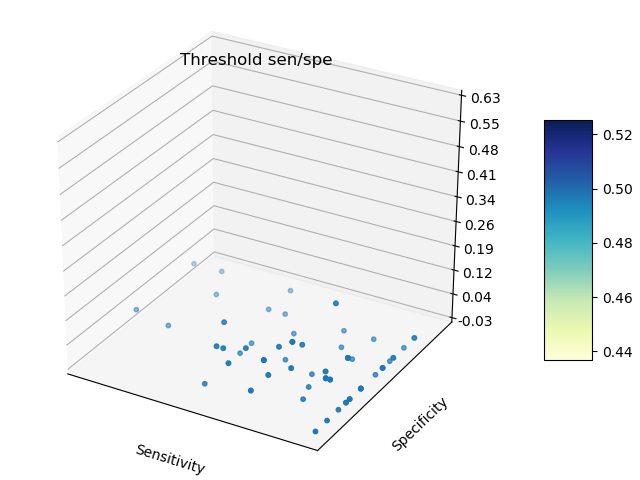

In [13]:
#plot 3D
%matplotlib notebook



X = data_frame_treated['N rule']
Y = data_frame_treated['N var per rule']
Z = data_frame_treated['f1']

y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(-1.01, 1.01)
ax.set_xticks(x_axis_values, minor=False)
ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Number of rules$')
ax.set_ylabel('$Number of var per rule$')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('F1-Score')
plt.show()

<b style="background-color:red;color:white">Question 11</b> In your opinion, which values/ranges of both parameters: number of rules and vars per rule, should you choose to obtain the best models? (comment briefly on the plot and include it into to report)

Don't forget to change those values below!

### Additional refinement of the parameter search

Now that we observed the plot we can refine the search for parameter values. As for the previous experiment it is necessary to:
<ul>
    <li>define new values/ranges for the number of rules </li>
    <li>define new values/ranges number of variable per rule </li>
    <li>change the path name where you want to save the new models </li>
    <li>change the name of the file that will contain the number of experiments</li>
     
</ul>

In [15]:
#Var per rule and number of rules


#Change the path directory where you want to save the new results
#--------------------
#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules_nvar_tuning/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules_nvar_tuning.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules_var_tuning'
#--------------------


model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)


#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience 
#('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [6]
var_per_rule_vec = [5]
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

gen	species	std       	min     	avg     	max     	avg_hof
1  	sp1    	0.00202926	0.547945	0.549117	0.552632	0.554  
1  	sp2    	0.243709  	0       	0.378366	0.6     	0.567735
2  	sp1    	0.00735071	0.583333	0.593876	0.6     	0.6     
2  	sp2    	0.26748   	0       	0.337564	0.611111	0.600463
3  	sp1    	0.00762419	0.591549	0.604323	0.619718	0.614037
3  	sp2    	0.261861  	0       	0.362849	0.619718	0.614037
4  	sp1    	0.00848358	0.594595	0.608694	0.619718	0.619718
4  	sp2    	0.253184  	0       	0.415078	0.637681	0.620467
5  	sp1    	0.00663693	0.611111	0.626963	0.637681	0.634265
5  	sp2    	0.257807  	0       	0.394072	0.637681	0.635024
6  	sp1    	0.00713508	0.611111	0.627532	0.637681	0.637681
6  	sp2    	0.246842  	0       	0.438984	0.637681	0.637681
7  	sp1    	0.0168633 	0.586667	0.605477	0.637681	0.637681
7  	sp2    	0.254019  	0       	0.435052	0.637681	0.637681
8  	sp1    	0.00946951	0.611111	0.627371	0.637681	0.637681
8  	sp2    	0.243044  	0       	0.4346  	0.656716	0.638474

70 	sp1    	0.0265187 	0.688525	0.749407	0.785714	0.785714
70 	sp2    	0.280117  	0       	0.469237	0.785714	0.785714
71 	sp1    	0.0257573 	0.676923	0.748085	0.785714	0.785714
71 	sp2    	0.277411  	0       	0.46997 	0.785714	0.785714
72 	sp1    	0.0243483 	0.709677	0.751538	0.785714	0.785714
72 	sp2    	0.26941   	0       	0.487599	0.785714	0.785714
73 	sp1    	0.0272452 	0.6875  	0.749183	0.785714	0.785714
73 	sp2    	0.237004  	0       	0.524202	0.785714	0.785714
74 	sp1    	0.0262733 	0.690909	0.74744 	0.785714	0.785714
74 	sp2    	0.291916  	0       	0.451493	0.785714	0.785714
75 	sp1    	0.0272012 	0.6875  	0.745271	0.785714	0.785714
75 	sp2    	0.274403  	0       	0.46015 	0.785714	0.785714
76 	sp1    	0.0264767 	0.677419	0.744032	0.785714	0.785714
76 	sp2    	0.290838  	0       	0.423278	0.785714	0.785714
77 	sp1    	0.0258063 	0.666667	0.746138	0.785714	0.785714
77 	sp2    	0.280669  	0       	0.458075	0.785714	0.785714
78 	sp1    	0.0280352 	0.666667	0.741982	0.785714	0.7857

39 	sp2    	0.27841   	0       	0.457665	0.741935	0.733594
40 	sp1    	0.0208513 	0.655738	0.708804	0.741935	0.736047
40 	sp2    	0.239115  	0       	0.515023	0.741935	0.736047
41 	sp1    	0.0217167 	0.666667	0.709377	0.741935	0.739482
41 	sp2    	0.279718  	0       	0.455256	0.741935	0.739973
42 	sp1    	0.0217437 	0.647059	0.711522	0.741935	0.741935
42 	sp2    	0.266162  	0       	0.487126	0.741935	0.741935
43 	sp1    	0.0206389 	0.645161	0.715851	0.741935	0.741935
43 	sp2    	0.280735  	0       	0.454801	0.754098	0.742949
44 	sp1    	0.0182712 	0.676471	0.735586	0.766667	0.751861
44 	sp2    	0.299697  	0       	0.427971	0.766667	0.752732
45 	sp1    	0.0220336 	0.677966	0.736685	0.766667	0.75946 
45 	sp2    	0.281973  	0       	0.466185	0.766667	0.75946 
46 	sp1    	0.020099  	0.677966	0.740329	0.766667	0.762644
46 	sp2    	0.296808  	0       	0.431858	0.766667	0.762644
47 	sp1    	0.023985  	0.645161	0.740591	0.766667	0.764655
47 	sp2    	0.251737  	0       	0.511692	0.766667	0.7649

8  	sp2    	0.292151  	0       	0.457629	0.724638	0.724638
9  	sp1    	0.0170994 	0.657895	0.706013	0.724638	0.724638
9  	sp2    	0.298877  	0       	0.446356	0.724638	0.724638
10 	sp1    	0.0163942 	0.666667	0.701527	0.724638	0.724638
10 	sp2    	0.274477  	0       	0.498209	0.724638	0.724638
11 	sp1    	0.0179422 	0.666667	0.701231	0.724638	0.724638
11 	sp2    	0.297194  	0       	0.422588	0.724638	0.724638
12 	sp1    	0.018098  	0.657895	0.708061	0.724638	0.724638
12 	sp2    	0.285494  	0       	0.478877	0.724638	0.724638
13 	sp1    	0.0181228 	0.675676	0.708058	0.724638	0.724638
13 	sp2    	0.2804    	0       	0.493784	0.724638	0.724638
14 	sp1    	0.0172285 	0.675676	0.706388	0.724638	0.724638
14 	sp2    	0.307021  	0       	0.428382	0.724638	0.724638
15 	sp1    	0.0168827 	0.666667	0.705875	0.724638	0.724638
15 	sp2    	0.304276  	0       	0.455563	0.753623	0.725845
16 	sp1    	0.0188455 	0.675676	0.714511	0.753623	0.7339  
16 	sp2    	0.267894  	0       	0.518263	0.753623	0.7343

78 	sp1    	0.0238091 	0.694444	0.749353	0.776119	0.776119
78 	sp2    	0.23051   	0       	0.552394	0.776119	0.776119
79 	sp1    	0.0206678 	0.685714	0.752242	0.776119	0.776119
79 	sp2    	0.265467  	0       	0.510801	0.776119	0.776119
80 	sp1    	0.0194183 	0.704225	0.749794	0.776119	0.776119
80 	sp2    	0.280429  	0       	0.502628	0.776119	0.776119
81 	sp1    	0.0185499 	0.694444	0.752173	0.776119	0.776119
81 	sp2    	0.273447  	0       	0.518927	0.776119	0.776119
82 	sp1    	0.0203312 	0.704225	0.746145	0.776119	0.776119
82 	sp2    	0.275665  	0       	0.520966	0.776119	0.776119
83 	sp1    	0.0237701 	0.684932	0.74466 	0.776119	0.776119
83 	sp2    	0.257867  	0       	0.523896	0.776119	0.776119
84 	sp1    	0.0216348 	0.704225	0.745504	0.776119	0.776119
84 	sp2    	0.282219  	0       	0.481149	0.776119	0.776119
85 	sp1    	0.0216932 	0.684932	0.74426 	0.776119	0.776119
85 	sp2    	0.256983  	0       	0.535543	0.776119	0.776119
86 	sp1    	0.0262877 	0.666667	0.741663	0.776119	0.7761

47 	sp1    	0.0397934 	0.588235	0.663894	0.72    	0.717484
47 	sp2    	0.266807  	0       	0.422233	0.72    	0.717484
48 	sp1    	0.0375078 	0.583333	0.667208	0.72    	0.71761 
48 	sp2    	0.216336  	0       	0.492332	0.72    	0.71761 
49 	sp1    	0.0392486 	0.584615	0.66548 	0.72    	0.718239
49 	sp2    	0.246534  	0       	0.472588	0.72    	0.718239
50 	sp1    	0.0427387 	0.526316	0.665064	0.72    	0.718742
50 	sp2    	0.26759   	0       	0.434576	0.72    	0.718742
51 	sp1    	0.0374664 	0.603175	0.673527	0.72    	0.719748
51 	sp2    	0.245715  	0       	0.465091	0.72    	0.719748
52 	sp1    	0.0431528 	0.53125 	0.666743	0.72    	0.72    
52 	sp2    	0.254103  	0       	0.453143	0.72    	0.72    
53 	sp1    	0.040902  	0.578947	0.66748 	0.72    	0.72    
53 	sp2    	0.247942  	0       	0.438276	0.72    	0.72    
54 	sp1    	0.0456273 	0.55    	0.664547	0.72    	0.72    
54 	sp2    	0.246929  	0       	0.457446	0.72    	0.72    
55 	sp1    	0.0479857 	0.526316	0.662846	0.72    	0.72  

16 	sp1    	0.0223434	0.588235	0.647657 	0.677966 	0.677966
16 	sp2    	0.275328 	0       	0.406394 	0.677966 	0.677966
17 	sp1    	0.0223585	0.588235	0.650818 	0.677966 	0.677966
17 	sp2    	0.247248 	0       	0.463735 	0.677966 	0.677966
18 	sp1    	0.0234332	0.597015	0.651964 	0.689655 	0.67894 
18 	sp2    	0.266971 	0       	0.432678 	0.701754 	0.683828
19 	sp1    	0.0229516	0.588235	0.662683 	0.701754 	0.691168
19 	sp2    	0.277866 	0       	0.421254 	0.701754 	0.691168
20 	sp1    	0.0252731	0.57971 	0.662382 	0.701754 	0.691672
20 	sp2    	0.280662 	0       	0.412626 	0.701754 	0.691672
21 	sp1    	0.0283248	0.57971 	0.66334  	0.701754 	0.695705
21 	sp2    	0.252934 	0       	0.474074 	0.701754 	0.695705
22 	sp1    	0.0281378	0.597015	0.666057 	0.701754 	0.698225
22 	sp2    	0.262788 	0       	0.446166 	0.701754 	0.698225
23 	sp1    	0.026744 	0.606061	0.668532 	0.701754 	0.701754
23 	sp2    	0.246705 	0       	0.457633 	0.701754 	0.701754
24 	sp1    	0.0265486	0.606061	0.668391 

84 	sp2    	0.274675 	0       	0.430037 	0.754717 	0.754717
85 	sp1    	0.0429368	0.606061	0.705831 	0.754717 	0.754717
85 	sp2    	0.273452 	0       	0.433474 	0.754717 	0.754717
86 	sp1    	0.0417922	0.606061	0.703468 	0.754717 	0.754717
86 	sp2    	0.292312 	0       	0.382868 	0.754717 	0.754717
87 	sp1    	0.0451236	0.6     	0.695665 	0.754717 	0.754717
87 	sp2    	0.261324 	0       	0.448467 	0.754717 	0.754717
88 	sp1    	0.0451915	0.6     	0.68884  	0.754717 	0.754717
88 	sp2    	0.272194 	0       	0.439285 	0.754717 	0.754717
89 	sp1    	0.0468616	0.6     	0.693921 	0.754717 	0.754717
89 	sp2    	0.256566 	0       	0.443622 	0.754717 	0.754717
90 	sp1    	0.0471852	0.606061	0.694356 	0.754717 	0.754717
90 	sp2    	0.275236 	0       	0.450429 	0.754717 	0.754717
91 	sp1    	0.0464163	0.606061	0.694197 	0.754717 	0.754717
91 	sp2    	0.283903 	0       	0.467571 	0.754717 	0.754717
92 	sp1    	0.0421557	0.606061	0.703585 	0.754717 	0.754717
92 	sp2    	0.279133 	0       	0.447476 

### Consolidating the results
Now, put all yours models in the same directory (copy/past) and add all the csv results to the dataframe in order to analyse the results

In [16]:
#Filter sen/spe
#read all csv
dataframe_results = pd.read_csv('values_number_of_rules.csv')
dataframe_results_b = pd.read_csv('values_number_of_rules_nvar.csv')
dataframe_results_c = pd.read_csv('values_number_of_rules_nvar_tuning.csv')
#dataframe_results_d = pd.read_csv('values_rmse_weight_v2.csv')
#dataframe_results_e = pd.read_csv('values_sen_spe_weight.csv')

dataframe_results_all = dataframe_results_b.append(dataframe_results)
dataframe_results_all = dataframe_results_all.append(dataframe_results_c)
#dataframe_results_all = dataframe_results_all.append(dataframe_results_d)
#dataframe_results_all = dataframe_results_all.append(dataframe_results_e)

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results_all.columns = ['N rule', 'N var per rule','weight','CV number', 'tn', 'fp', 'fn', 'tp', 'file_name']
dataframe_results_all = dataframe_results_all.reset_index(drop=True)
display(dataframe_results_all)

N rule  N var per rule  weight  CV number   tn   fp   fn   tp  \
0      6.0             2.0     1.0        0.0  3.0  5.0  5.0  1.0   
1      6.0             2.0     1.0        1.0  2.0  7.0  0.0  5.0   
2      6.0             2.0     1.0        2.0  4.0  8.0  0.0  2.0   
3      6.0             2.0     1.0        3.0  4.0  2.0  1.0  7.0   
4      6.0             2.0     1.0        4.0  3.0  3.0  1.0  6.0   
..     ...             ...     ...        ...  ...  ...  ...  ...   
80     6.0             5.0     1.0        0.0  4.0  4.0  2.0  4.0   
81     6.0             5.0     1.0        1.0  3.0  6.0  2.0  3.0   
82     6.0             5.0     1.0        2.0  7.0  5.0  0.0  2.0   
83     6.0             5.0     1.0        3.0  5.0  1.0  3.0  5.0   
84     6.0             5.0     1.0        4.0  2.0  4.0  1.0  6.0   

                                            file_name  
0   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
1   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
2   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
3   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
4   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
..                                                ...  
80  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
81  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
82  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
83  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
84  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  

[85 rows x 9 columns]

# 2 Model selection

Once we have tested all the configurations, we have obtained a **large** number of models exhibiting diverse performance figures. At the end of a modeling process, the goal is to obtain one, or a few, models that would be deployed and used for new predictions. A selection process is thus necessary.

A first selection is performed by applying a filter based on the diagnostic performance, thus reducing the number of models. Below you can see a scatter plot of all the models you obtained according to their sensitivity and specificity (as obtained on the validation subsets).

In [17]:
#Plot sent spe all

#Plot all values
#don't forget to turn off the others plotss
vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(dataframe_results_all)
#vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(data_frame_treated)

plt.scatter(vec_values_sen_spe_models['Sensitivity'],vec_values_sen_spe_models['Specificity'],s=10, marker='o')

plt.title('Threshold sen/spe')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.savefig('ScatterPlot.png')

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()
print('You have {0} models'.format(len(vec_values_sen_spe_models)))


You have 85 models


## First selection filter: based on sen/spe

Having analysed the above performance overview of your models, you can apply a filter based on  sensitivity and specificity. In this way, only those models exhibiting better performance than some specified threshold will be selected for the next step.
The plot below shows the effect of the combined thresholds on the number of models remaining after the filter is applied.

<IPython.core.display.Javascript object>


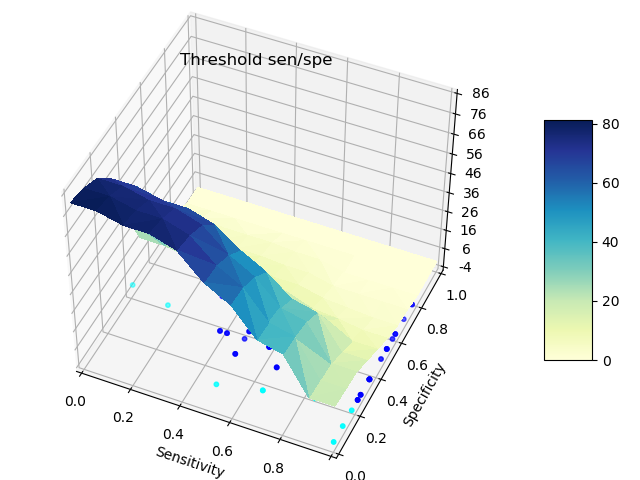

In [18]:
#Plot sen_spe  qty models 3D
#that save x models
%matplotlib notebook

results_qty_models = libraries.interpretability_methods.plotSenSpeQtyModelsByThreshold(vec_values_sen_spe_models)

#display(results_qty_models)

X = results_qty_models['sensitivity']
Y = results_qty_models['specificity']
Z = results_qty_models['qty_models']

#y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
#x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)

max_quantity = results_qty_models.loc[results_qty_models['qty_models'].idxmax()]
max_quantity = int(max_quantity['qty_models'])

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z.values,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(0, max_quantity)
ax.set_zticks(Z)
#ax.set_xticks(x_axis_values, minor=False)
#ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Sensitivity$')
ax.set_ylabel('$Specificity$')



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sen/Spe threshold')
plt.show()

On the base of this plot, you should decide on threshold values for both, specificity and sensitivity and apply them. The resulting subset of selected models is shown in the scatterplot below.

In [19]:
#select values sen spe filtre
%load_ext autoreload
%autoreload
#Put a limit in sen/spe
#Here you put the threshold for the sensitivity and specificity
#Don't forget to shave the plot and comment into your repport
#--------------------
value_sensitivity = 0.2
value_specificity = 0.2
#--------------------


#We apply them

vec_values_sen_spe_models_filtered = libraries.interpretability_methods.filterDataframeBySenSpeLimit(value_sensitivity, value_specificity, vec_values_sen_spe_models)
vec_values_sen_spe_models_filtered_invert = libraries.interpretability_methods.filterDataframeBySenSpeLimitContrary(value_sensitivity, value_specificity, vec_values_sen_spe_models)


figure = libraries.interpretability_plots.plotDataFrameValuesFiltered(value_sensitivity, value_specificity,vec_values_sen_spe_models_filtered, vec_values_sen_spe_models_filtered_invert)


print('You have {0} models'.format(len(vec_values_sen_spe_models_filtered)))
for index, row in vec_values_sen_spe_models_filtered.iterrows():
    print(index)
    print(row)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You have 74 models
1
index                                                          1
Sensitivity                                                    1
Specificity                                             0.222222
file_name      exps_lab_lfa_number_of_rules_var_weigh_actual_...
Name: 1, dtype: object
2
index                                                          2
Sensitivity                                                    1
Specificity                                             0.333333
file_name      exps_lab_lfa_number_of_rules_var_weigh_actual_...
Name: 2, dtype: object
3
index                                                          3
Sensitivity                                                0.875
Specificity                                             0.666667
file_name      exps_lab_lfa_number_of_rules_var_weigh_actual_...
Name: 3, dtype: object
4
index                               

<b style="background-color:red;color:white">Question 12</b>: Explain your choice of the threshold values for the sensitivity and specificity. (Save both plots into your reports)

<b>Save the plot on the repport</b>

## Second selection: frequency-based filter

Next, a second model-selection filter is applied based on the "importance" of the features. Such feature importance is represented in this context by their relative presence (i.e. their frequency) among the models. 

#### Frequency of the variables
The figure below shows the frequency of the variables among all the remaining models.

In [44]:
%load_ext autoreload
%autoreload
  
    
#--------------------
list_models_path_complete = ["experiences/all_models/exps_lab_lfa_number_of_rules_var_tuning_weigh_actual_1.0_conf_A_CV_3_rule_6_var_per_rule_5.ftt"
                            ]
#--------------------
    
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You have 1 models and 20 variables


<IPython.core.display.Javascript object>


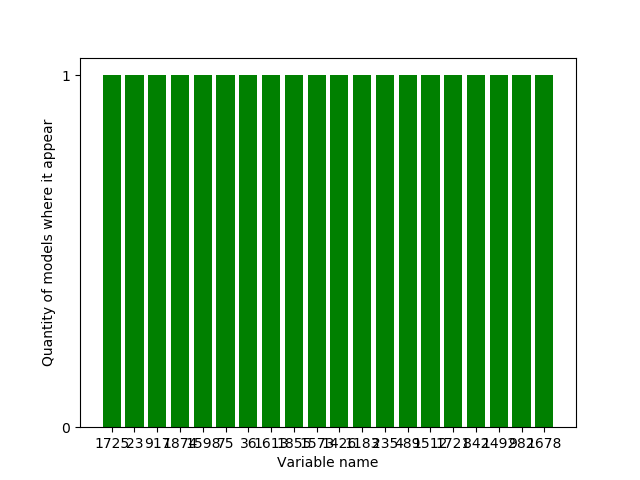

In [45]:
#plot histogram before cut

dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_models_vars)




#indication of the number of models and variables
qty_models = len(list_models_vars)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)


#### Choosing a frequency threshold
Filtering features by frequency will result in a reduction of both the number of features and the number of models, as models with eliminated variables are also eliminated. 

The plot below represents the number of models and variables that should remain after the filter is applied in function of the frequency threshold. It helps you to decide on which threshold to use for the filter.

(Note that the frequency of a feature is calculated as the number of <b>different models</b> where it appears irrespective of the number of rules containing it.)

In [46]:
%load_ext autoreload
%autoreload
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)
dict_values = libraries.interpretability_methods.countVarFreq(list_models_vars)


#TEST zone
matrix_results = libraries.interpretability_methods.createPlotQtyVarPerModelByMinimumFreq(dict_values,list_models_vars)
#display(matrix_results)
#End test zone



ax = plt.figure().gca()

matrix_results.plot(kind='line',x='min freq var',y='number of models',ax=ax)
matrix_results.plot(kind='line',x='min freq var',y='quantity of variables', color='red', ax=ax)

plt.show()

#libraries.interpretability_plots.plotFreqVarPerFreqMinimum(matrix_results)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

based on the plot above, select the minimum frequency (threshold) for the variables on your models.

<b style="background-color:red;color:white">Question 13</b>: Explain your choice of the threshold. (Save both plots into your report)

You need to indicate the name of the file where you want to save the models

In [48]:
#valide the frequence value

#Create a copy of the list that contains the model_var objects
list_models_vars_cpopy = list_models_vars.copy()
#select the minimum frequenty
#-------------------
nb_min_var = 1
#--------------------

#Perform the frequence
list_model_var_resultant = libraries.interpretability_methods.reduceQtyVars(nb_min_var, dict_values,list_models_vars_cpopy)
dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_model_var_resultant)




#indication of the number of models and variables
qty_models = len(list_model_var_resultant)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)
#Show the frequency table
dict_Values_ordered = libraries.interpretability_methods.sort_reverse_dictionary_by_values(dict_values_resultant)
datafram_var_freq = pd.DataFrame(list(dict_Values_ordered.items()),columns=['Variable name','Frequence'])
display(datafram_var_freq)


#Perform the list of the models
#--------------------
file_name = 'models_selected.csv'
#--------------------
list_models_names=[model_var.model_path for model_var in list_model_var_resultant]
dataframe_names_files = pd.DataFrame(list_models_names)
dataframe_names_files.to_csv(file_name, sep=',', encoding='utf-8')

You have 1 models and 20 variables


<IPython.core.display.Javascript object>

Variable name  Frequence
0           1725          1
1             23          1
2            917          1
3           1874          1
4           1598          1
5             75          1
6             36          1
7           1613          1
8           1855          1
9           1573          1
10          1426          1
11          1183          1
12           235          1
13           489          1
14          1512          1
15          1721          1
16           842          1
17          1492          1
18           982          1
19          1678          1

Carlos: Don't forget to save the plot resultant of your choice...
<br>
<b>The objective of the lab is to arrived at the end with 5-10 models

# 3. Analysis of the selected models

Now that you have selected the best models, they are saved on the file "models_selected.CSV" (Or other file if you change the name...)
You may then load these models and use them to compute their predictions for the observations in the test set.

In [43]:
%reload_ext autoreload
%autoreload

# Import from file
#--------------------
fis = TrefleFIS.from_tff_file("experiences/all_models/exps_lab_lfa_number_of_rules_var_tuning_weigh_actual_1.0_conf_A_CV_0_rule_6_var_per_rule_5.ftt")
#--------------------
# In the future, it could possible to call clf.predict_classes() directly
# see issue #1
y_pred_test = fis.predict(X_test)

results_list_predictions = np.squeeze(np.asarray(y_pred_test))


#libraries.results_plot.plotCMByTreflePredictions(y_test, results_list_predictions)
#Convert your results into binary values
results = []
for element in y_pred_test:
    print(element)
    if element >= 0.5:
        results.append(1)
    else:
        results.append(0)
print(results)
from libraries.ConfusionMatrix import ConfusionMatrix
cm = confusion_matrix(y_test, results)

n_classes = 2
print(cm)
ConfusionMatrix.plot(cm, classes=range(n_classes), title="Confusion Matrix")


[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[21  0]
 [14  0]]


The code above is only an example of how to load models and test their performance in the test set. (Remember that the test set is the one who has not been used during the previous training/selectionn steps.)

<b><span style="background-color:red;color:white">Question 14</span></b>: Among the final models, select three of them as follows: the smallest one (in terms of rules and variables), the best one (in terms of performance), and one in the "middle" that you consider as being a good trade-off between size and performance. With them:
<ul>
    <li>Apply them to the test set and analyze the results you obtained</li>
    <li>Analyze them in terms of size, rules, vars per rules and other characteristics that you think are relevant</li>
    <li>As far as possible, analyze their rules and try to "explain" their predictions.
</ul>
<br>
Tips: You can use plots to described your results...